In [1]:
import numpy as np
import scipy
import pandas as pd
from glob import glob
import os
import pickle

import sys
sys.path.insert(0,r'/home/markus/repos/uni/16ma/bicycle/python')
from models.load_data_set import load_trajectories
from bicycle.plot_bicycle_trajectories import position, state
from bicycle import test_set, reward_functions
import evaluate

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
import holoviews as hv

hv.notebook_extension()
hv.ipython.display_hooks.ABBREVIATE_TRACEBACKS = False
%output holomap='auto' widgets='embed'
%output size=120 dpi=120 
%opts Points (s=20)
%opts Spread (alpha=0.4)
%opts Curve[show_title=True, title_format='{label}']
%opts Overlay[show_title=True show_grid=True title_format='{label}']
%opts Overlay.State[xaxis='bare', yaxis='bare']
%opts GridMatrix[padding=0.25 show_title=False xaxis=None yaxis=None normalize=False shared_xaxis=False shared_yaxis=False] {+framewise}
%opts Layout[show_title=True]
%opts NdOverlay[legend_cols=3 legend_position="bottom"] Points (color=Palette('Set1'))
%opts Table[aspect=3 max_value_len=50 max_font_size=30]

In [4]:
from glob import glob
import os, re

def path_to_dump_name(path):
    path = os.path.basename(path)
    path = re.sub('\.[^.]+\.npy', '', path)
    return path

def nice_dump_name(dump_name):
    parsed = dict(map(lambda x: x.split('='), dump_name.split('__')))
    if "posterior" in parsed:
        return " ".join("{}={}".format(k, parsed[k]) for k in ["posterior", "N", "M"])
    else:
        return " ".join("{}={}".format(k, parsed[k]) for k in ["simulation"])
    
def maybe_int(x):
    try:
        return int(x)
    except ValueError:
        return x
    
def parse_path(path, items=["posterior", "N", "M"]):
    short = path_to_dump_name(path)
    parsed = dict(map(lambda x: x.split("="), short.split("__")))
    if "no_posterior" in parsed["name"]:
        parsed["posterior"] = parsed["posterior"] + "_no_truncation"
    if "posterior" in parsed:
        return tuple(map(lambda it: maybe_int(parsed[it]), items))
    else:
        return ("simulation", 0, 0)    

In [5]:
dict_path = r'/home/markus/repos/uni/16ma/bicycle/eval_dicts/16_05_31/'

def unpickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

all_evals = [
    unpickle(eval_dict)
    for eval_dict in glob(os.path.join(dict_path, "*.pkl"))
]

evals = [
    {
        parse_path(name): item
        for name, item in one["mean_mean_reward"].items()
    }
    for one in all_evals
]

long_evals = [
    {
        (*name, ix): item
        for name, item in one.items()
    }
    for ix, one in enumerate(evals)
]

In [6]:
def collapse_evals(evals):
    result = {}
    for evl in evals:
        result.update(evl)
    return result

collapsed = collapse_evals(long_evals)

# Mean-Mean-Reward

b':Table   [posterior]   (Mean-Mean-Reward)'
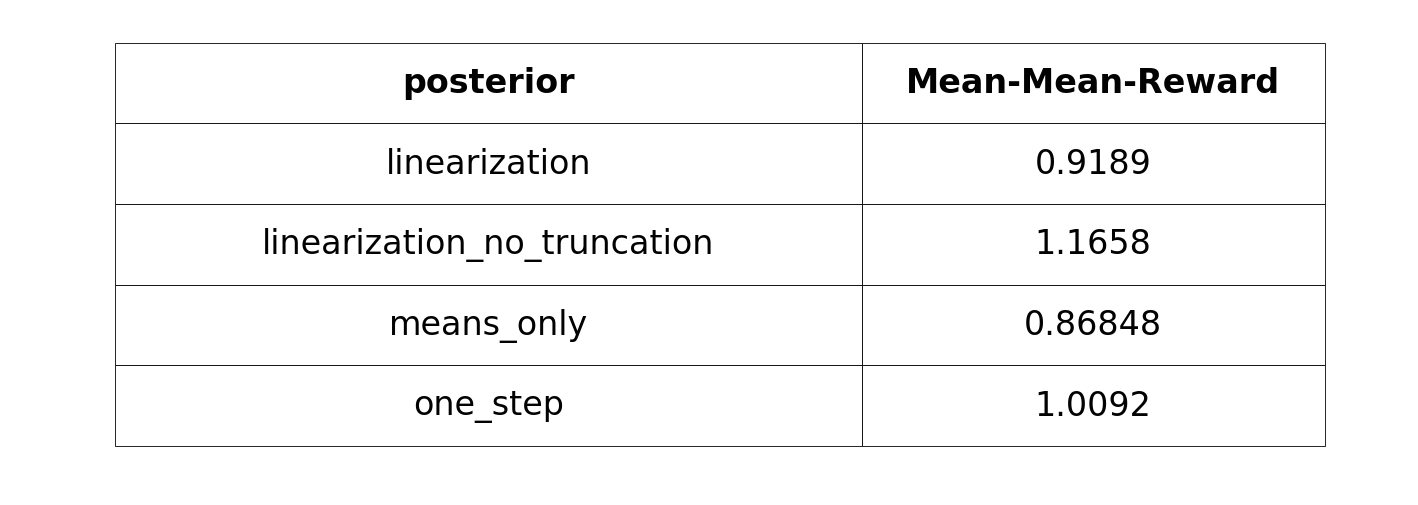

In [7]:
%%output size=400
table = hv.Table(collapsed, kdims=["posterior", "N", "M", "trial"], vdims=["Mean-Mean-Reward"])

table.reduce(["N", "M", "trial"], np.mean).sort()

b':HoloMap   [N,M]\n   :Table   [posterior]   (Mean-Mean-Reward)'
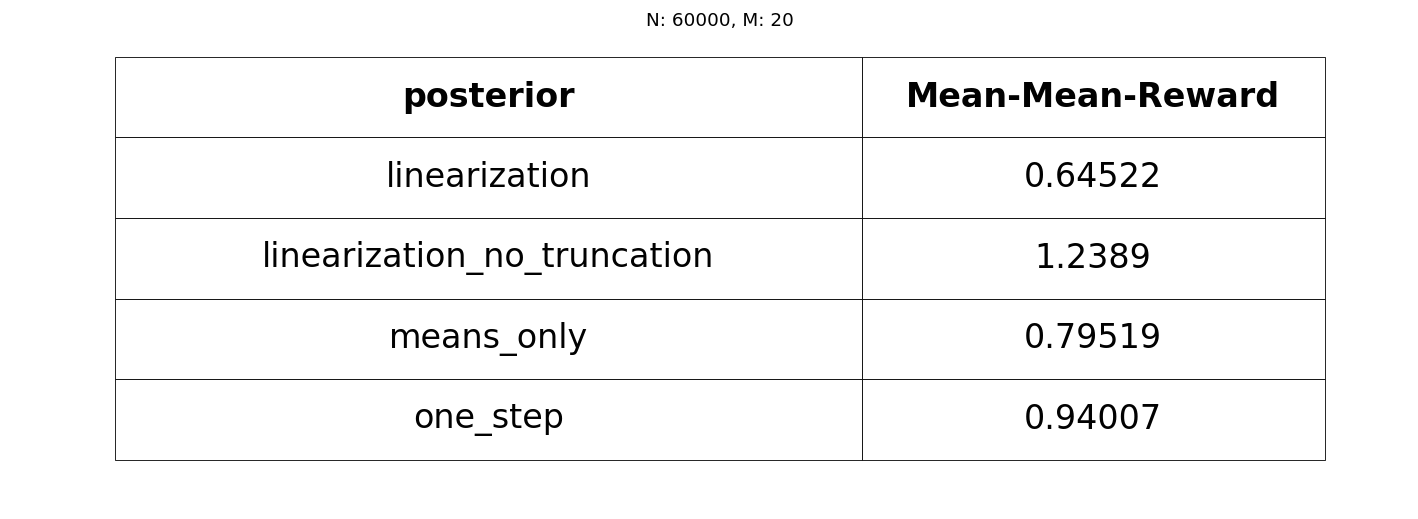
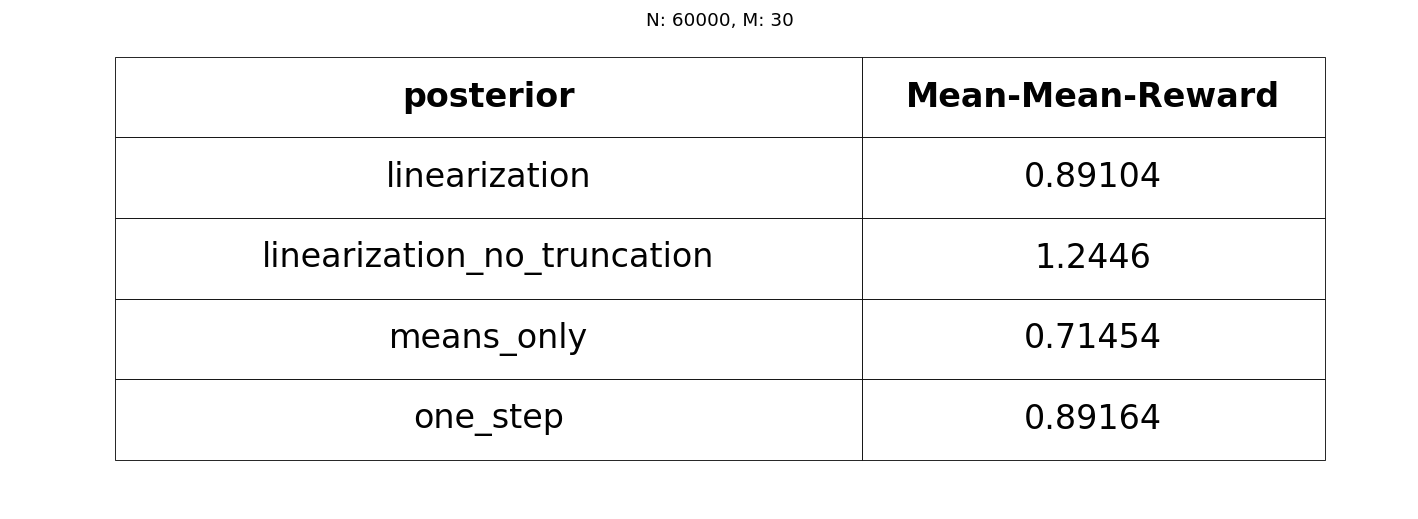
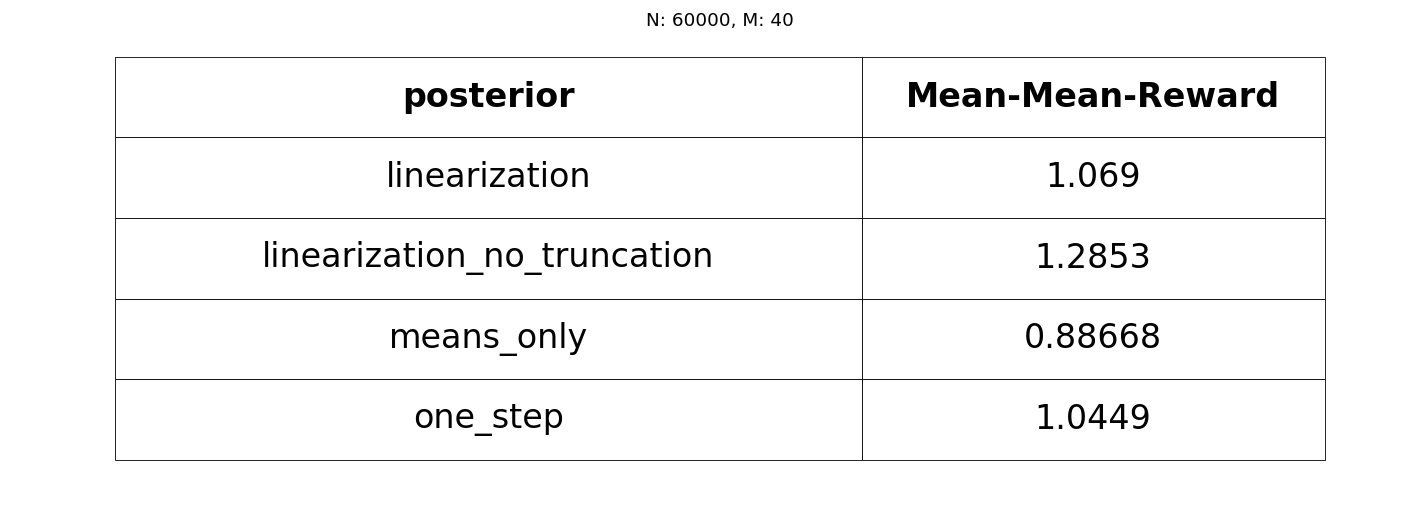
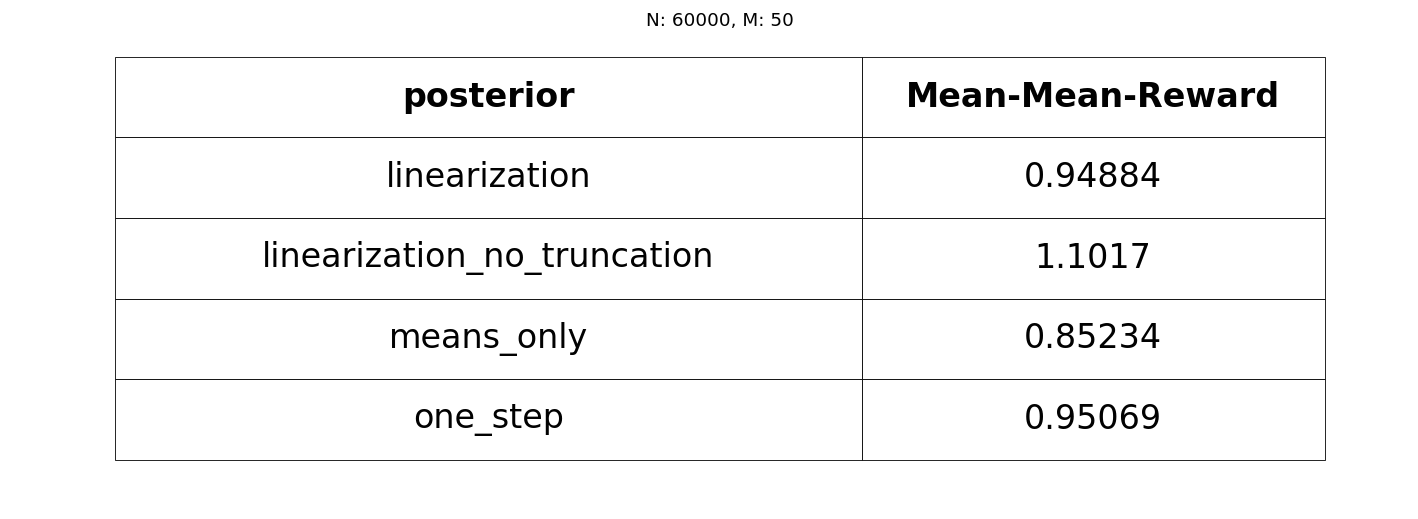
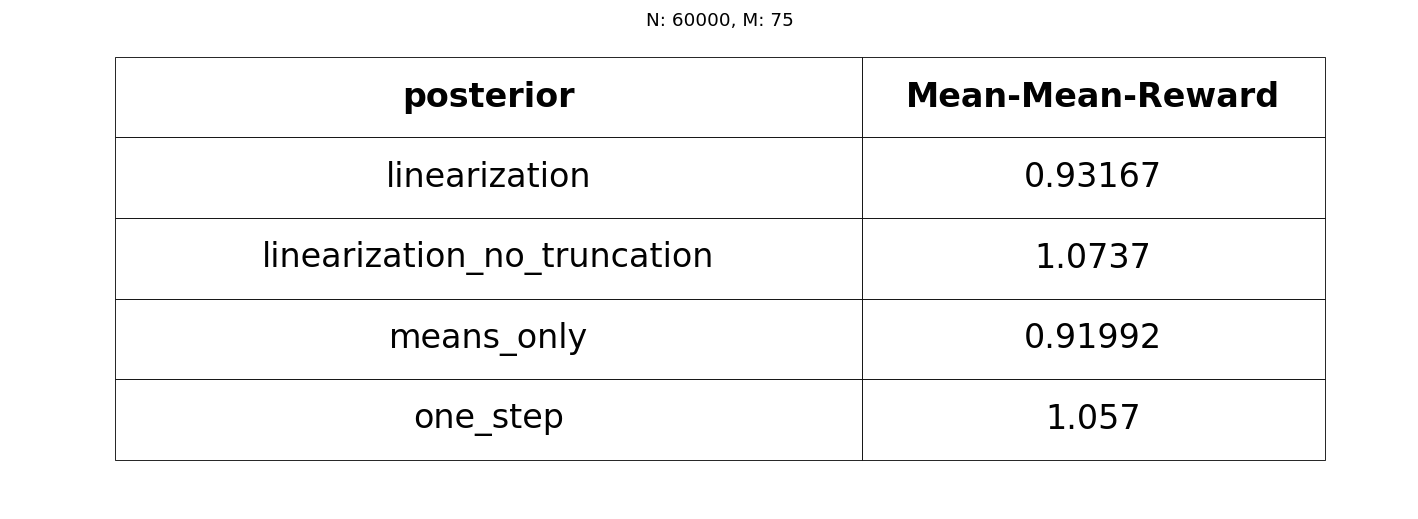
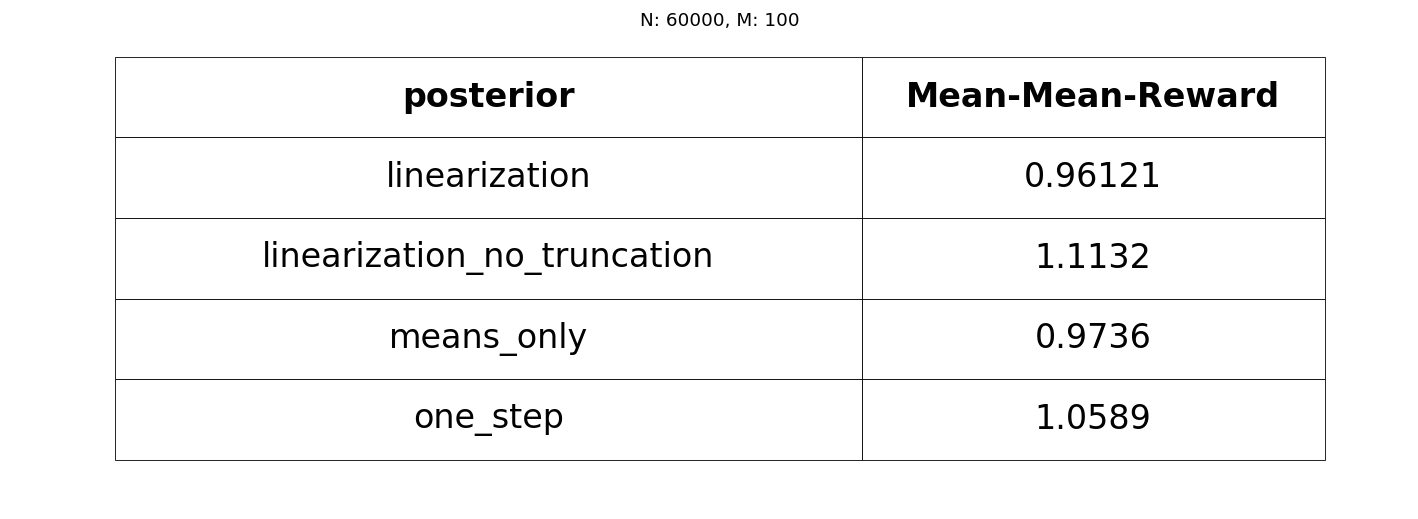
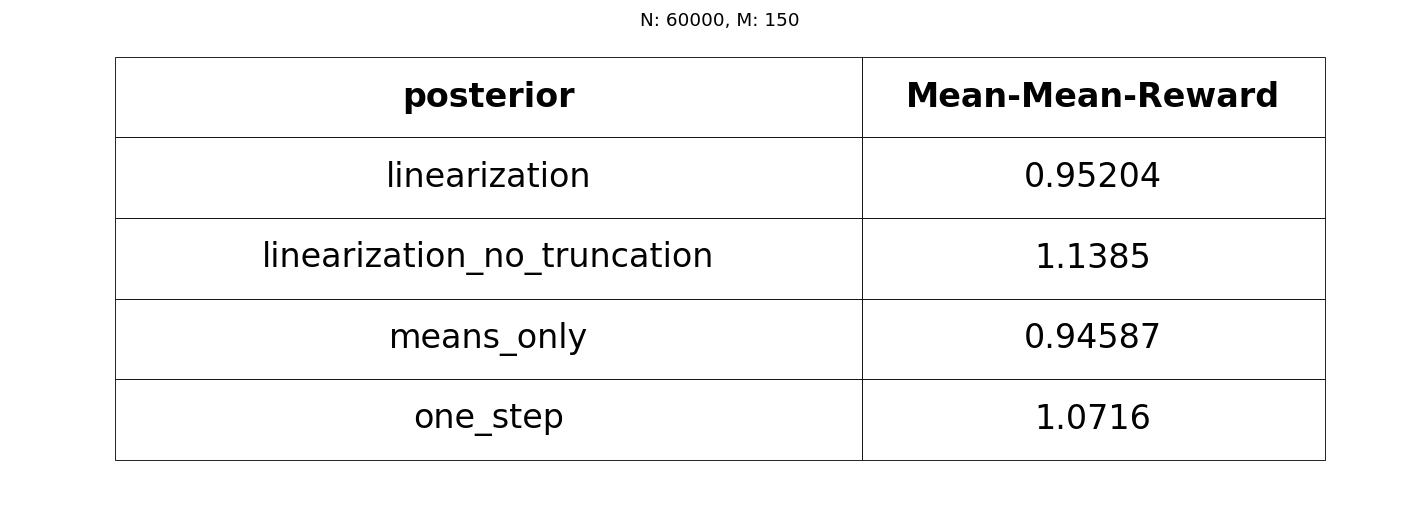
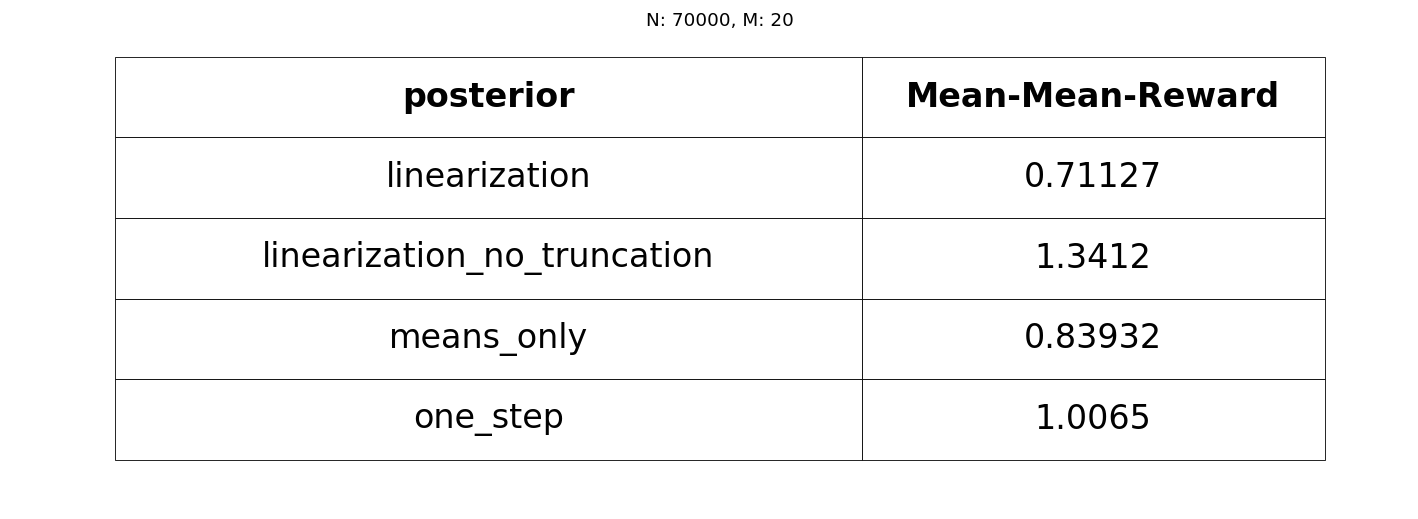
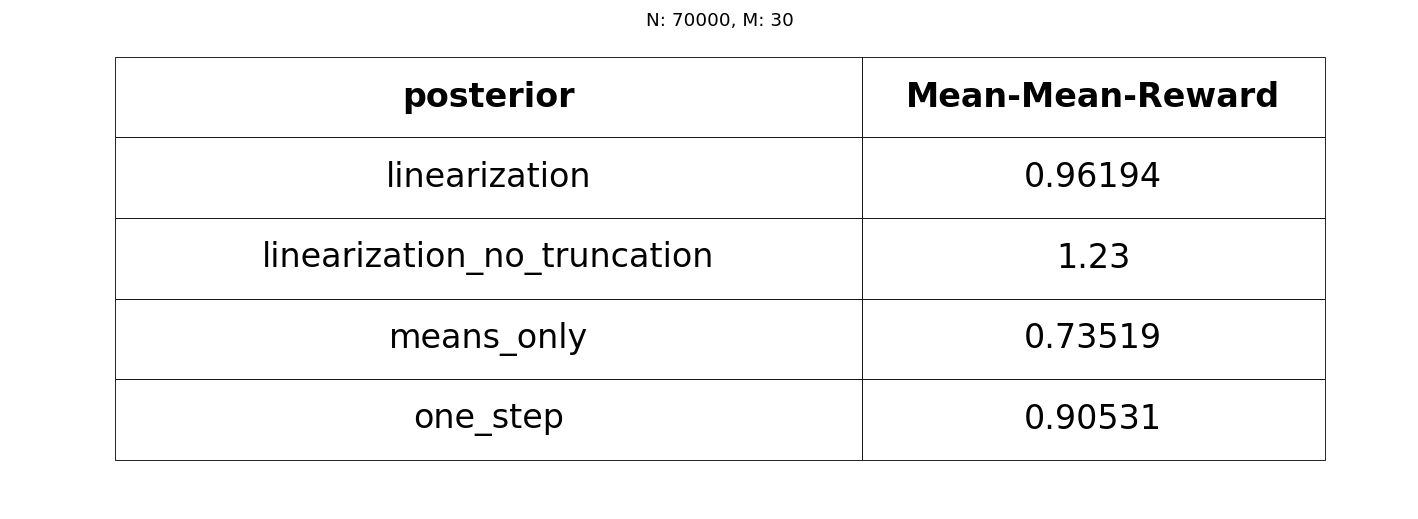
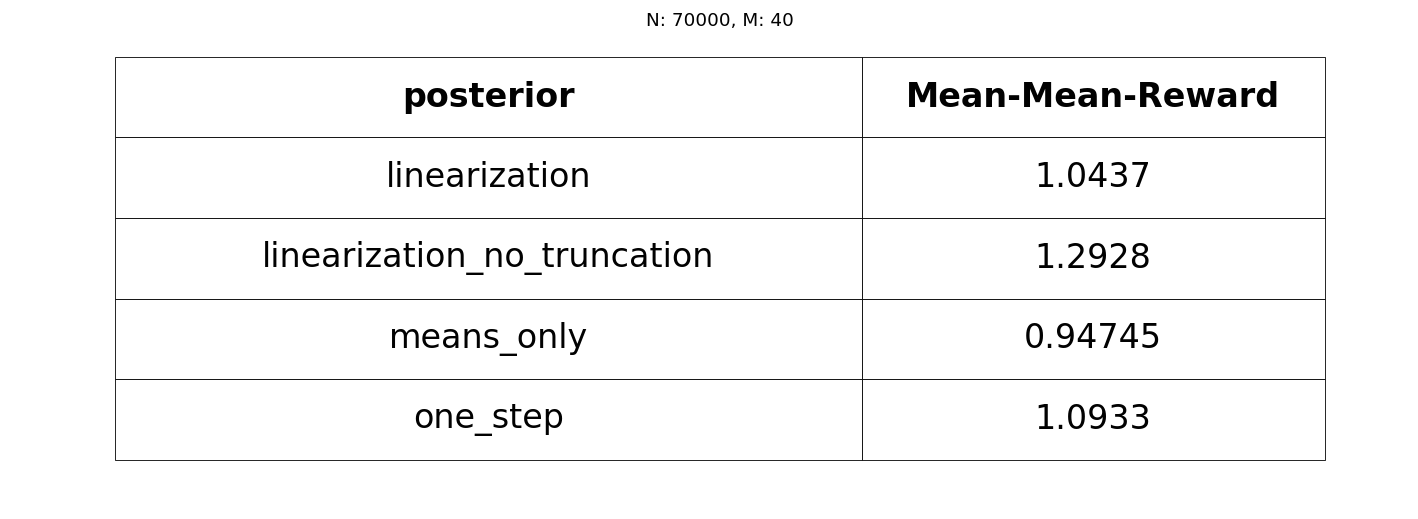
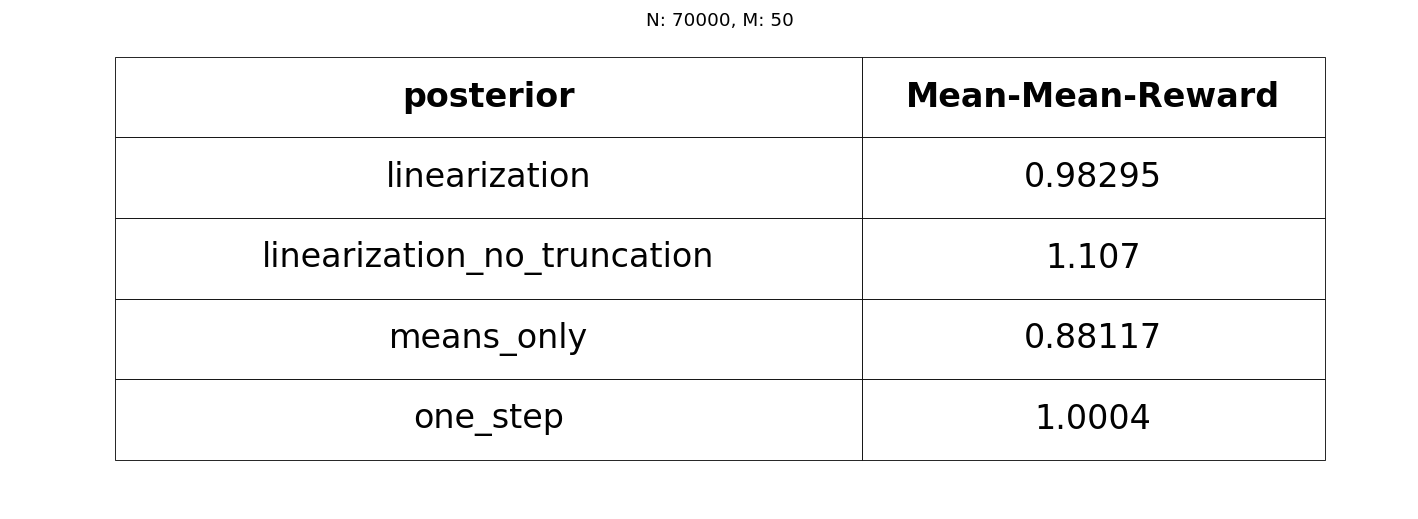
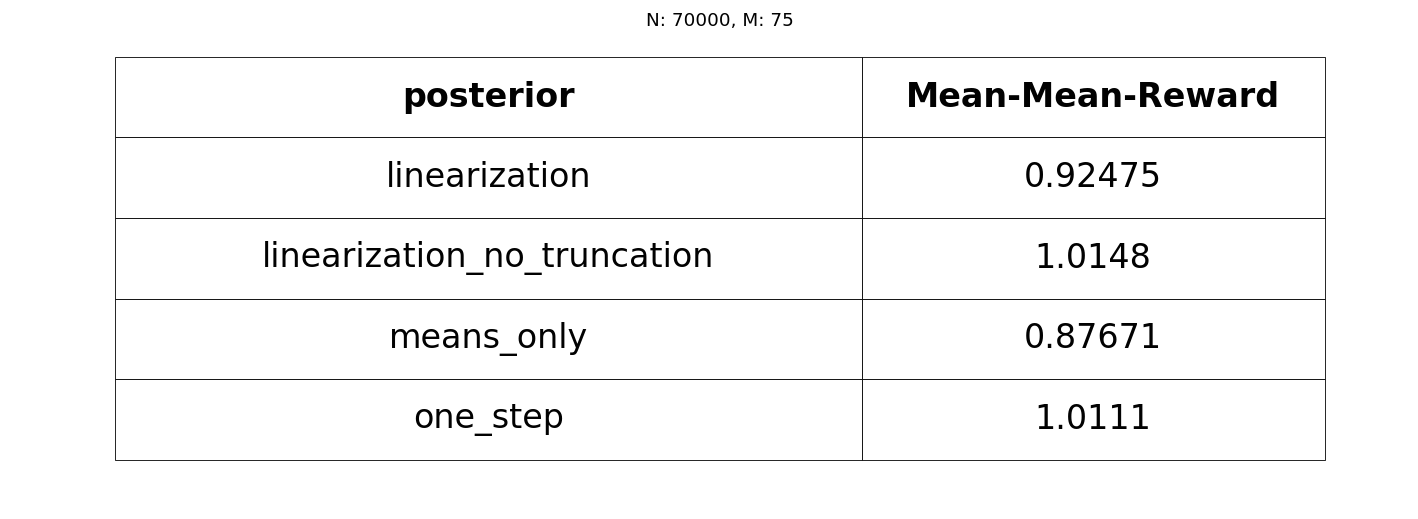
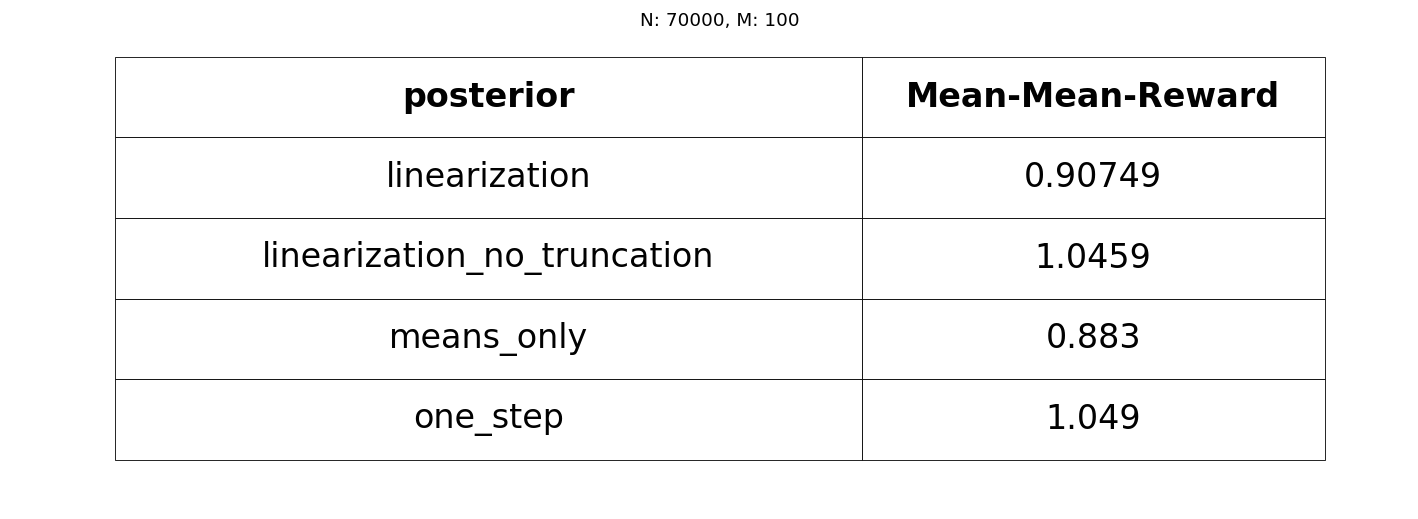
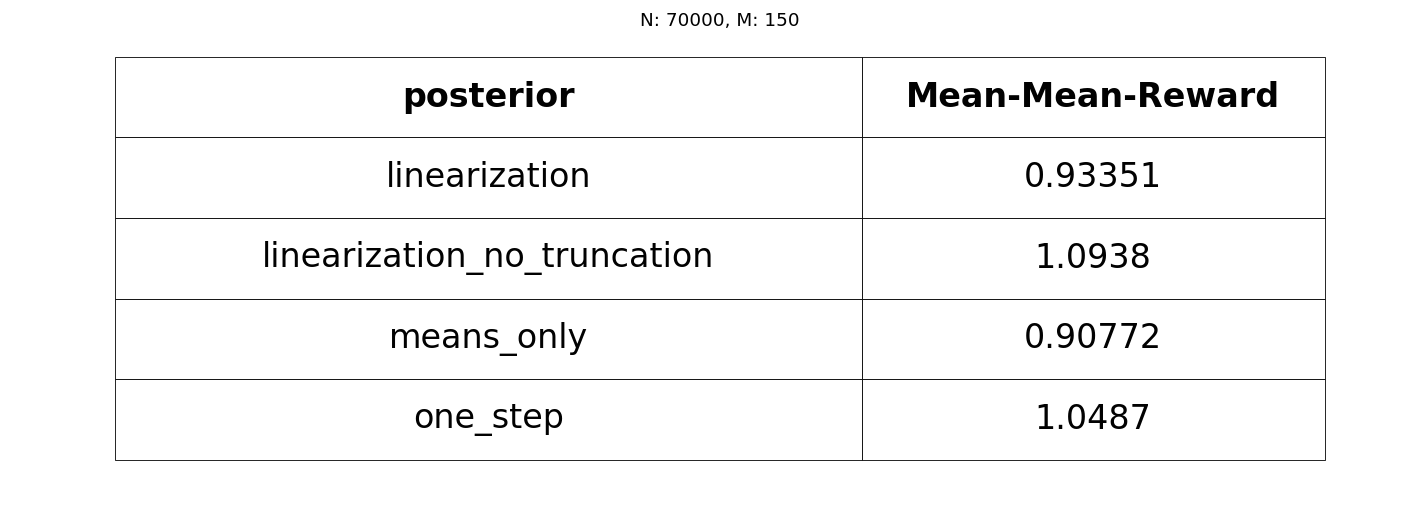

In [8]:
%%output size=400
table.reduce(["trial"], np.mean).sort().groupby(["N", "M"])

b':NdOverlay   [posterior]\n   :Curve   [M,Mean-Mean-Reward]   (Mean-Mean-Reward)'
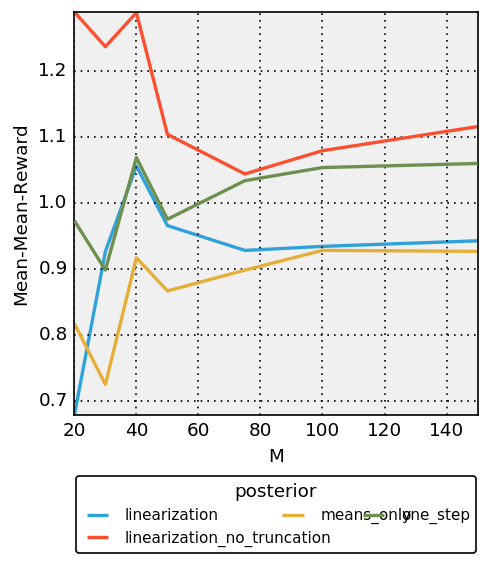

In [9]:
table.reduce(["trial", "N"], np.mean).to.curve(["M", "Mean-Mean-Reward"]).overlay()

:Overlay
   .Points.I :Points   [linearization_no_truncation,means_only]
   .Curve.I  :Curve   [x]   (y)
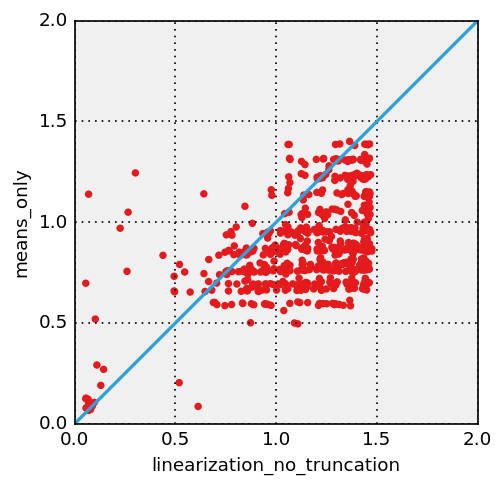

In [10]:
xs = table.select(posterior="linearization_no_truncation").sort()["Mean-Mean-Reward"]
ys = table.select(posterior="means_only").sort()["Mean-Mean-Reward"]

hv.Points((xs, ys), kdims=["linearization_no_truncation", "means_only"]) * hv.Curve(((0, 2), (0, 2)))

b':Table   [posterior,M]   (Mean-Mean-Reward,Mean-Mean-Reward_sem)'
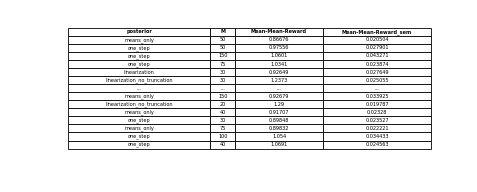

In [11]:
%%opts Spread (alpha=0.1)

reduced = table.reduce(["trial", "N"], np.mean, spreadfn=scipy.stats.sem)
reduced.to.spread(["M", "Mean-Mean-Reward"], "Mean-Mean-Reward_sem").overlay() * reduced.to.curve(["M", "Mean-Mean-Reward"]).overlay()
mean_mean_rewards = reduced
mean_mean_rewards

b':NdLayout   [posterior]\n   :HoloMap   [M]\n      :Distribution   (Mean-Mean-Reward)'
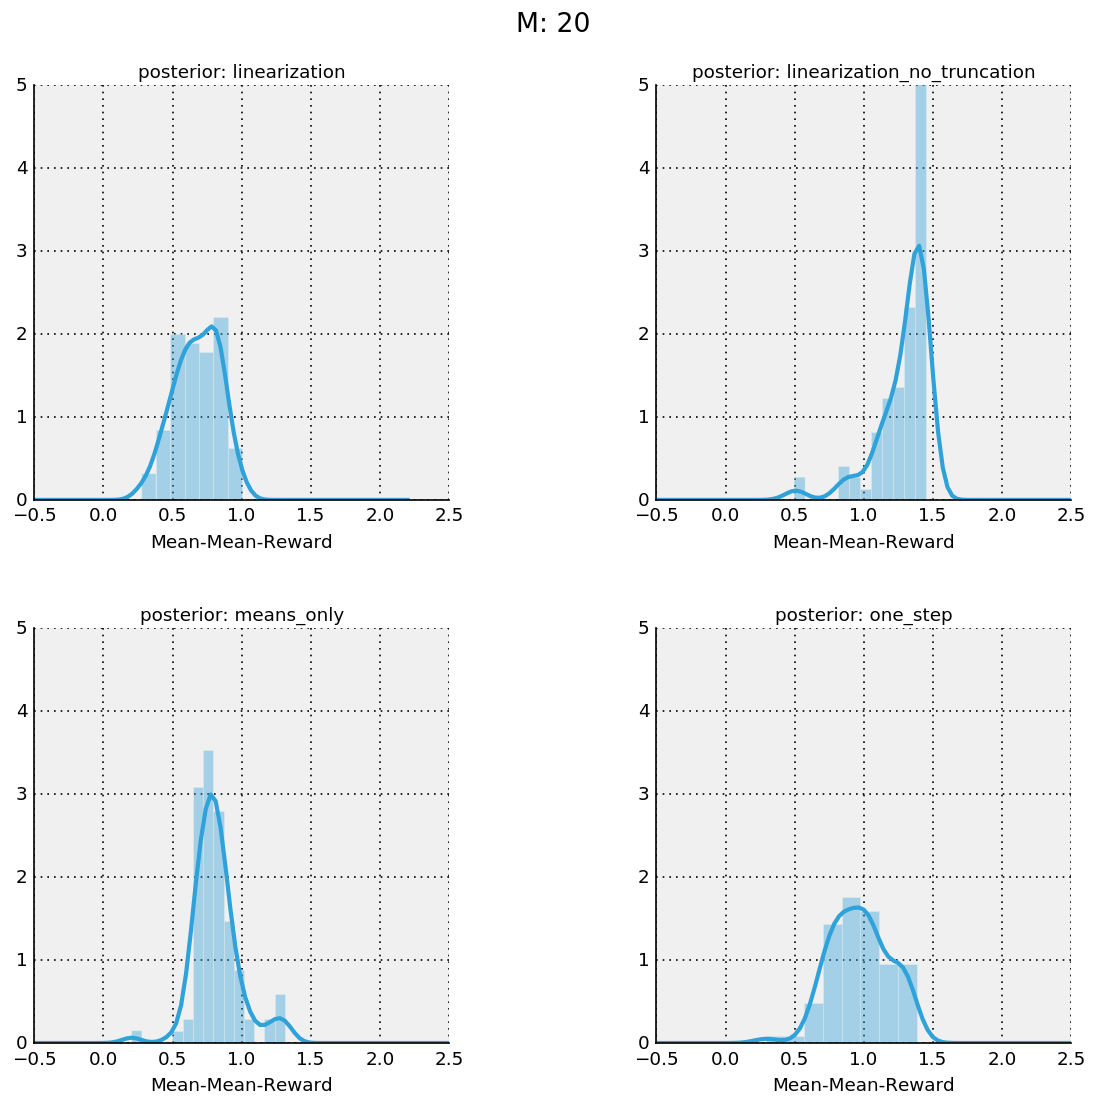
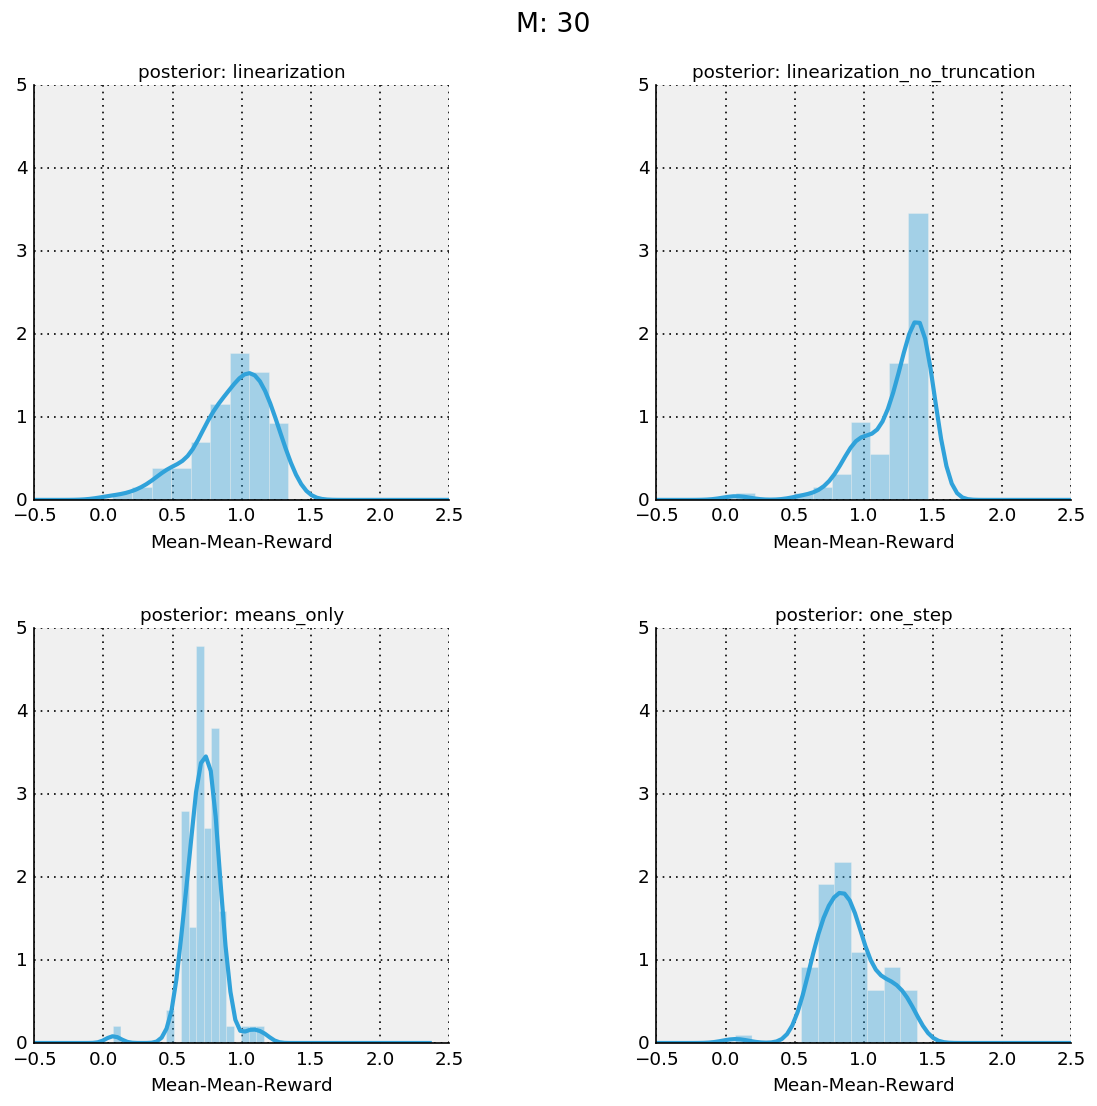
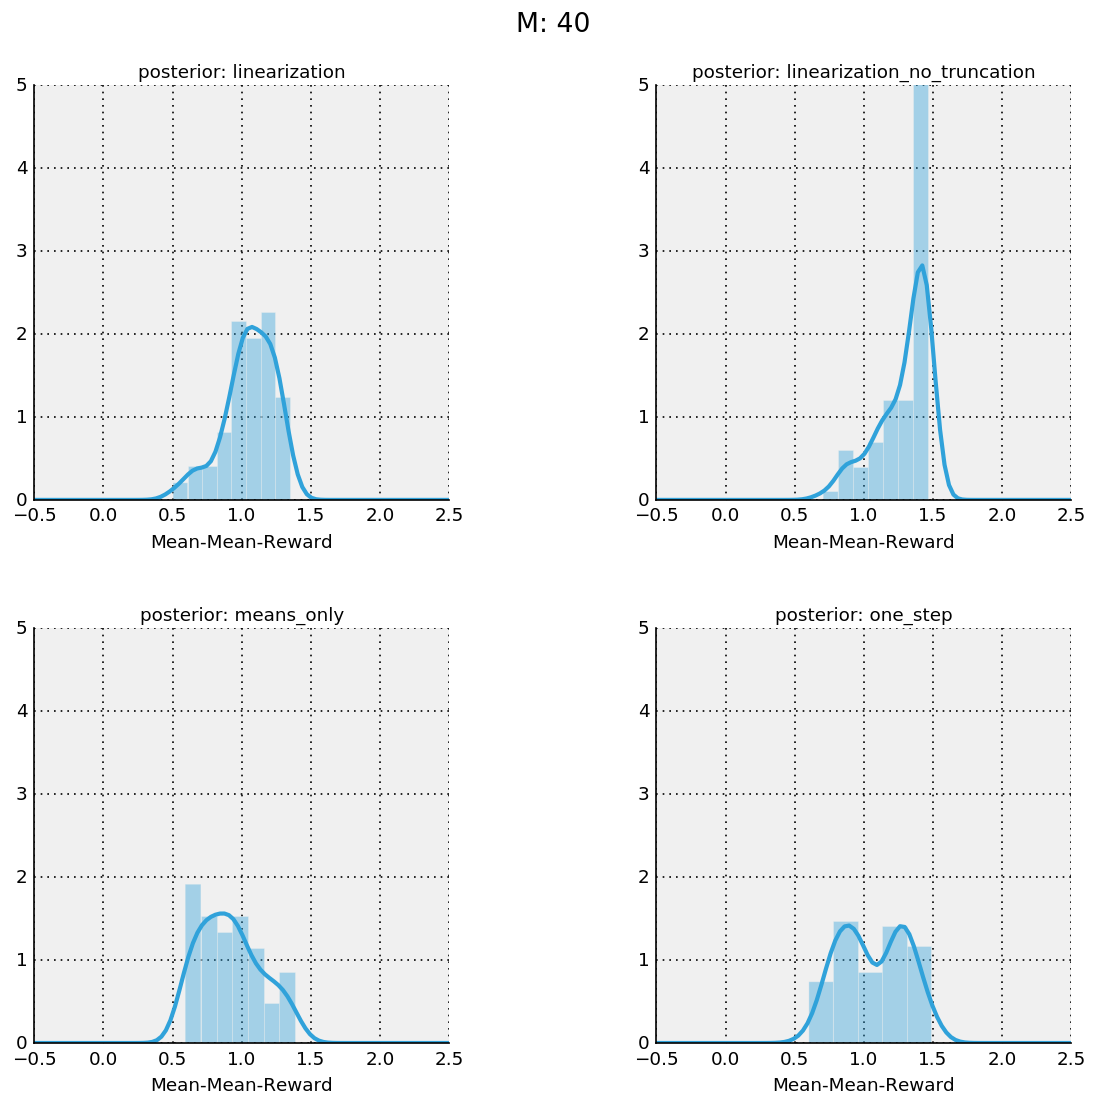
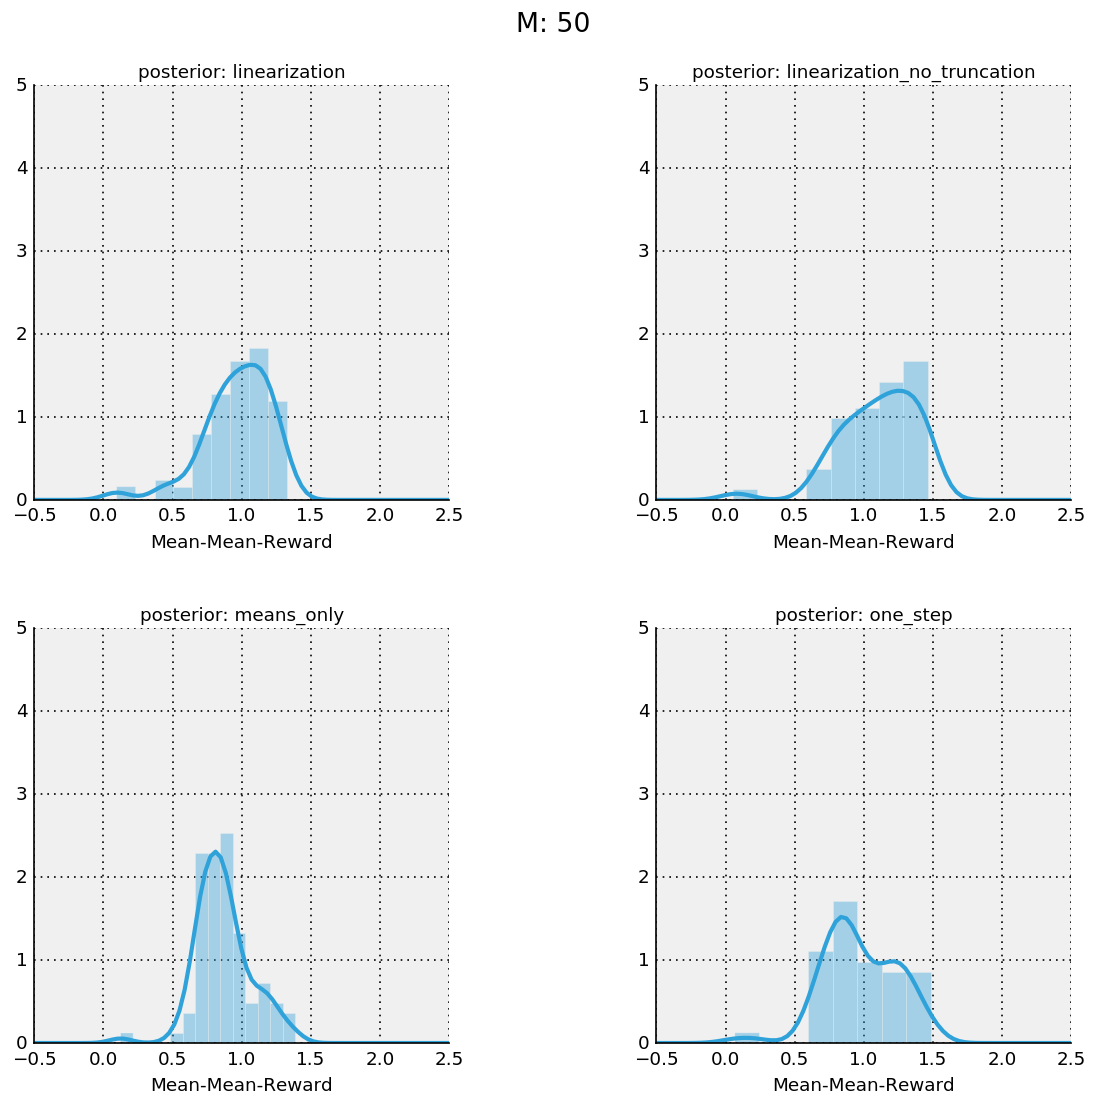
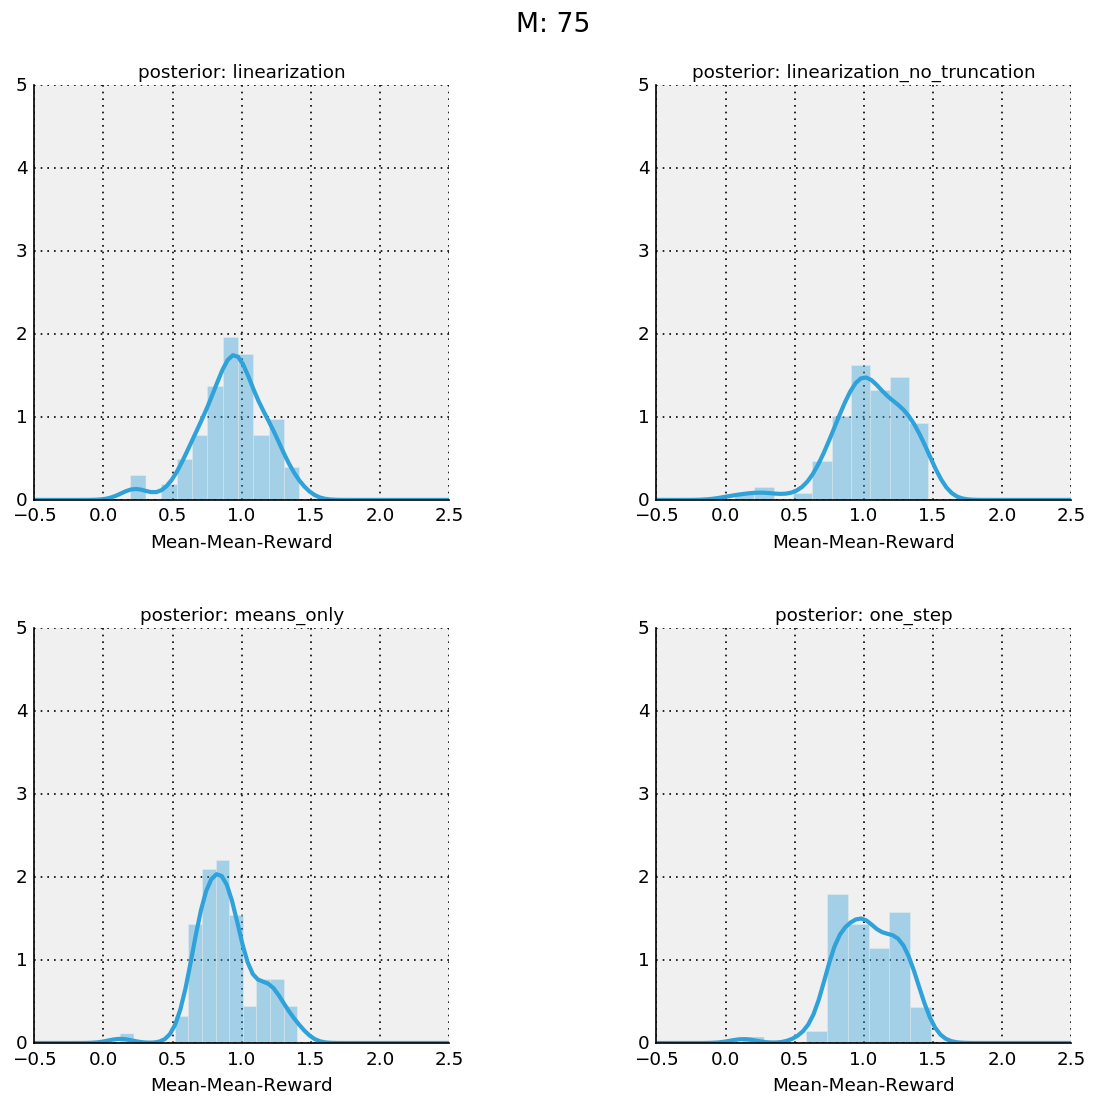
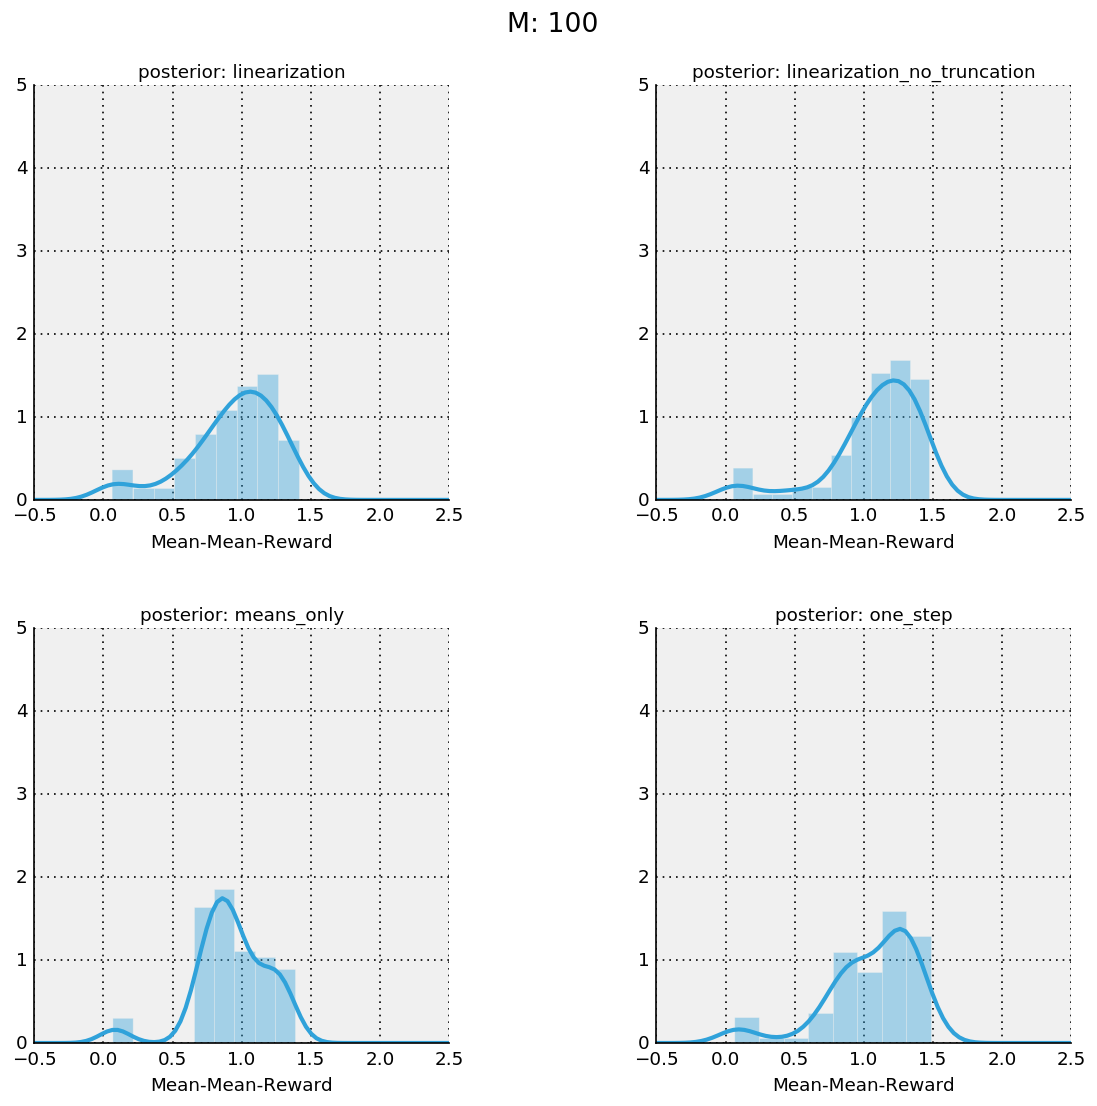
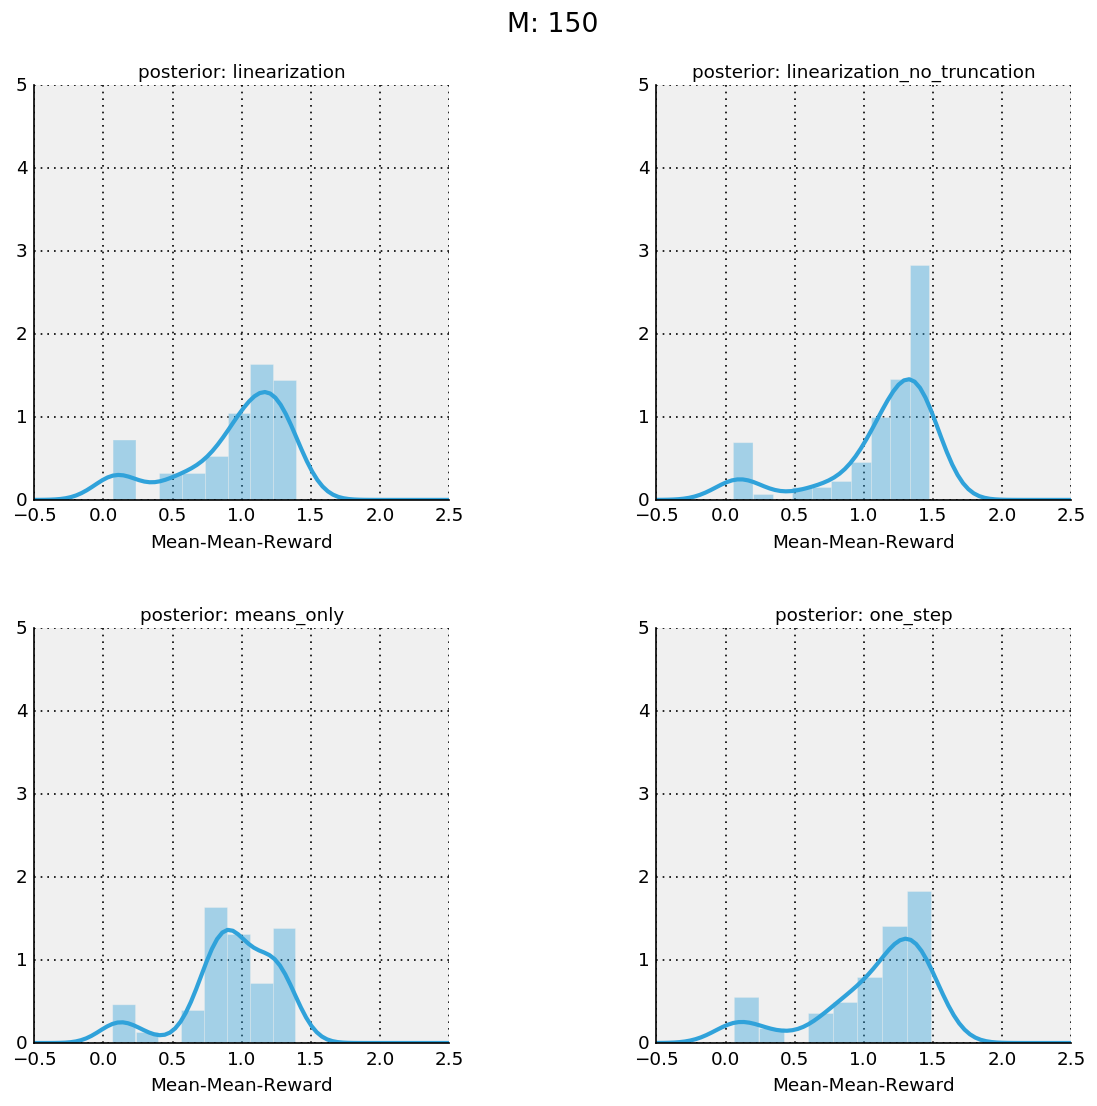

In [12]:
%%opts Distribution[apply_extents=True] HoloMap[apply_extents=True]
table.to.distribution("Mean-Mean-Reward", mdims=["M", "posterior"], extents=(-0.5, 0, 2.5, 5)).layout("posterior").cols(2)

In [13]:
df = pd.DataFrame(table.data)
df = df.set_index(["N", "M", "trial", "posterior"]).unstack("posterior")["Mean-Mean-Reward"]
diff = df["linearization_no_truncation"] - df["means_only"]

In [14]:
diff_table = hv.Table(diff.to_frame("Reward Difference").reset_index(), kdims=["N", "M", "trial"], vdims=["Reward Difference"])

b':HoloMap   [M]\n   :Distribution   (Reward Difference)'
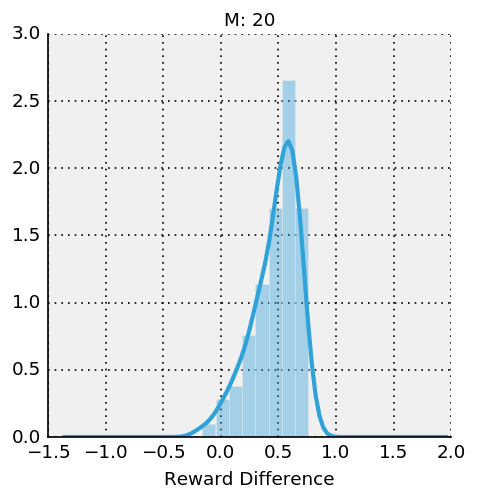
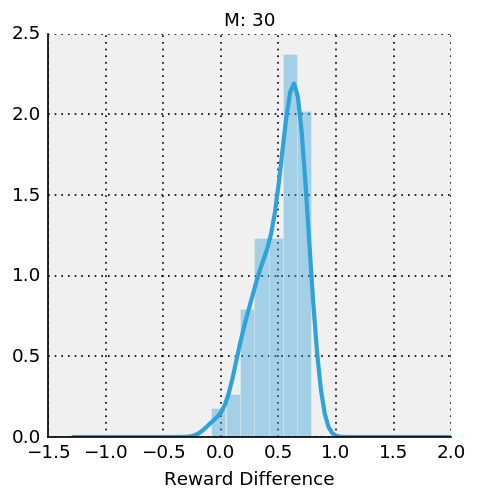
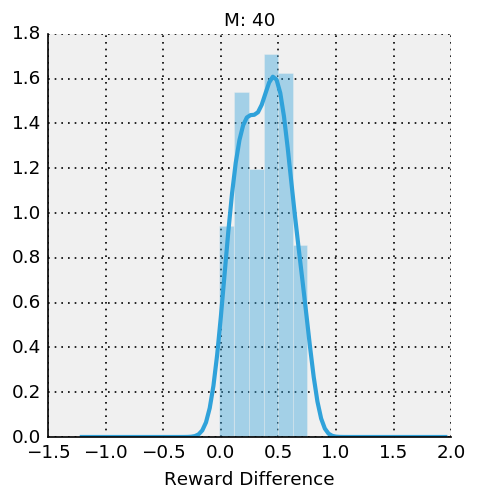
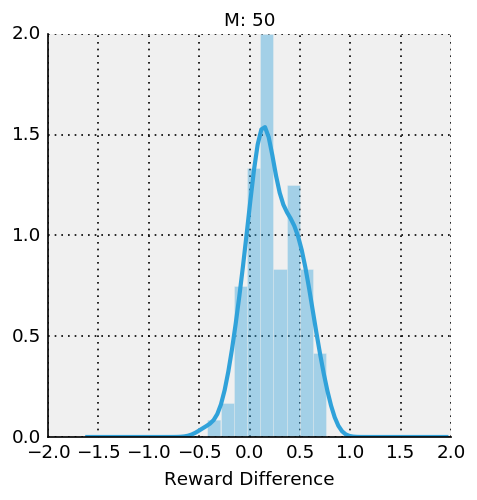
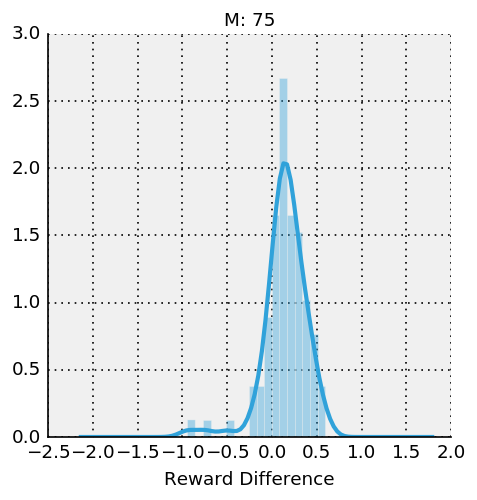
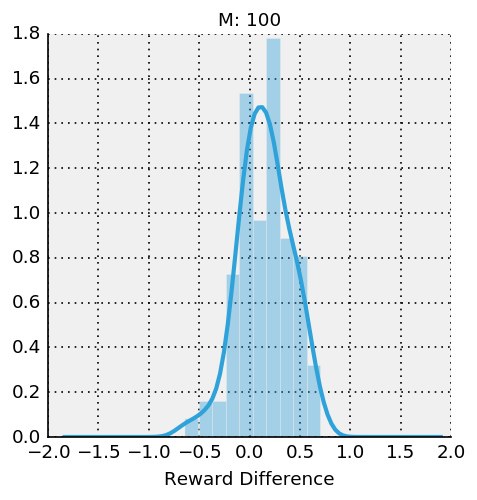
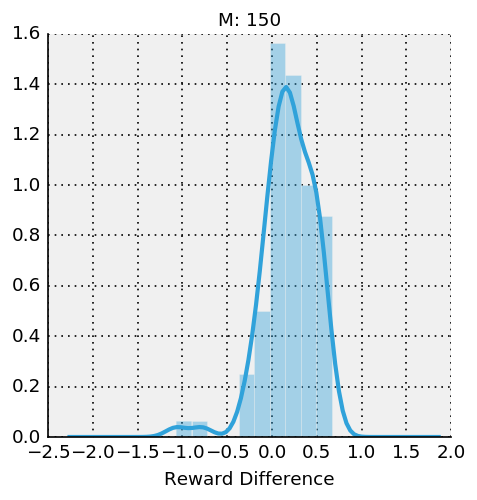

In [15]:
diff_table.to.distribution("Reward Difference", mdims=["M"])

b':HoloMap   [M]\n   :Distribution   (Reward Difference)'
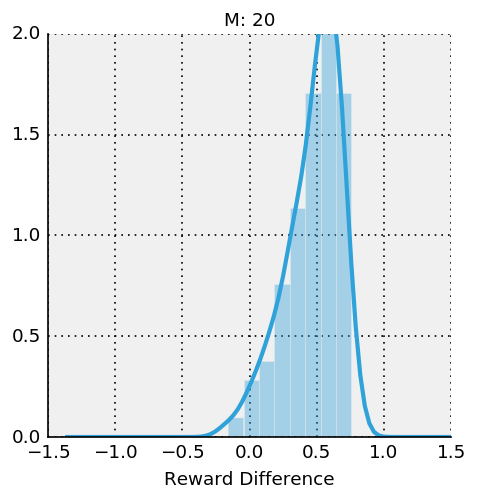
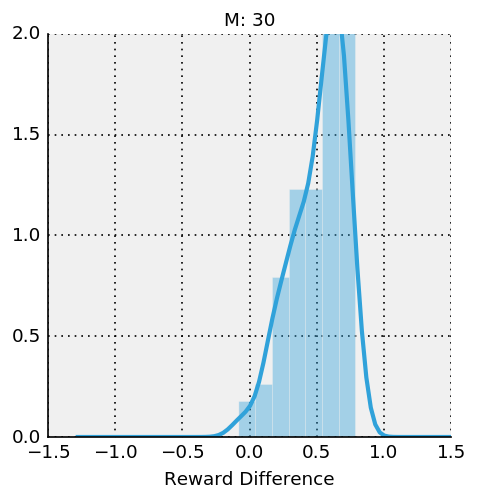
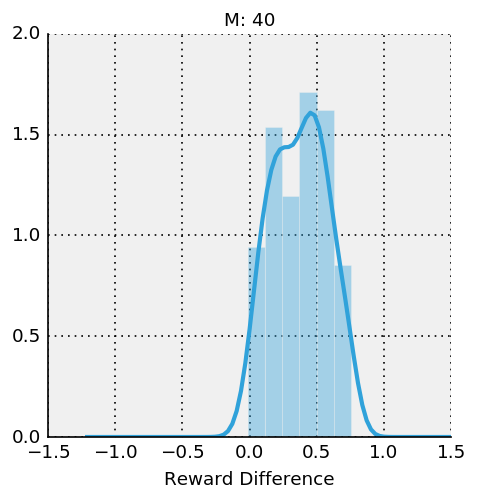
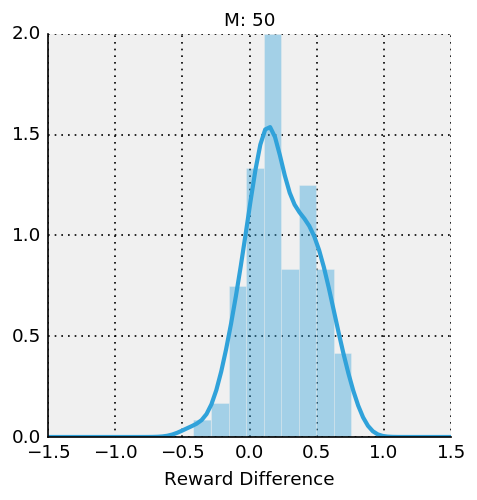
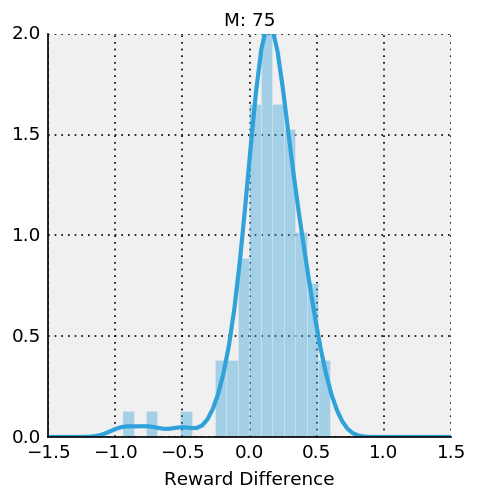
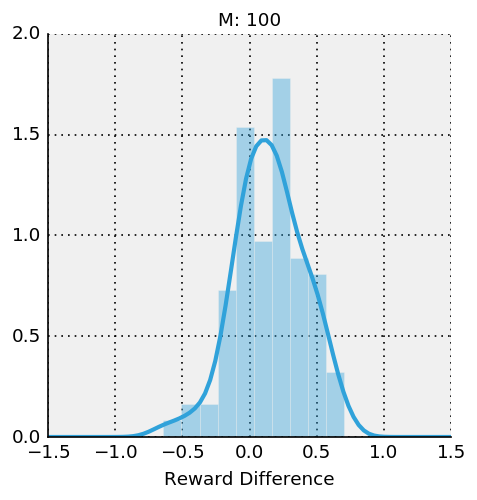
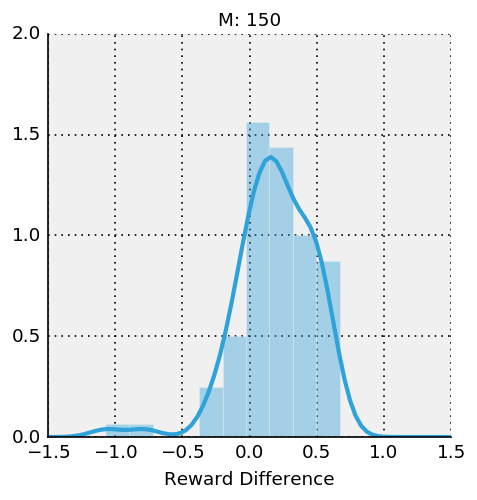

In [16]:
%%opts Distribution[apply_extents=True] HoloMap[apply_extents=True]
diff_table.to.distribution("Reward Difference", mdims=["M"], extents=(-1.5, 0, 1.5, 2), bins=20)

# Number of Goal hits

In [17]:
goal_evals = [
    {
        parse_path(name): item
        for name, item in one["counts"].items()
    }
    for one in all_evals
]

long_goal_evals = [
    {
        (*name, ix): item
        for name, item in one.items()
    }
    for ix, one in enumerate(goal_evals)
]

goal_collapsed = collapse_evals(long_goal_evals)
goal_collapsed = {
    name: (item["goal"], item["fallen"], item["too_long"], item["unfinished"], sum(item.values()))
    for name, item in goal_collapsed.items()
}

b':Table   [posterior]   (goal,fallen,too_long,unfinished,all)'
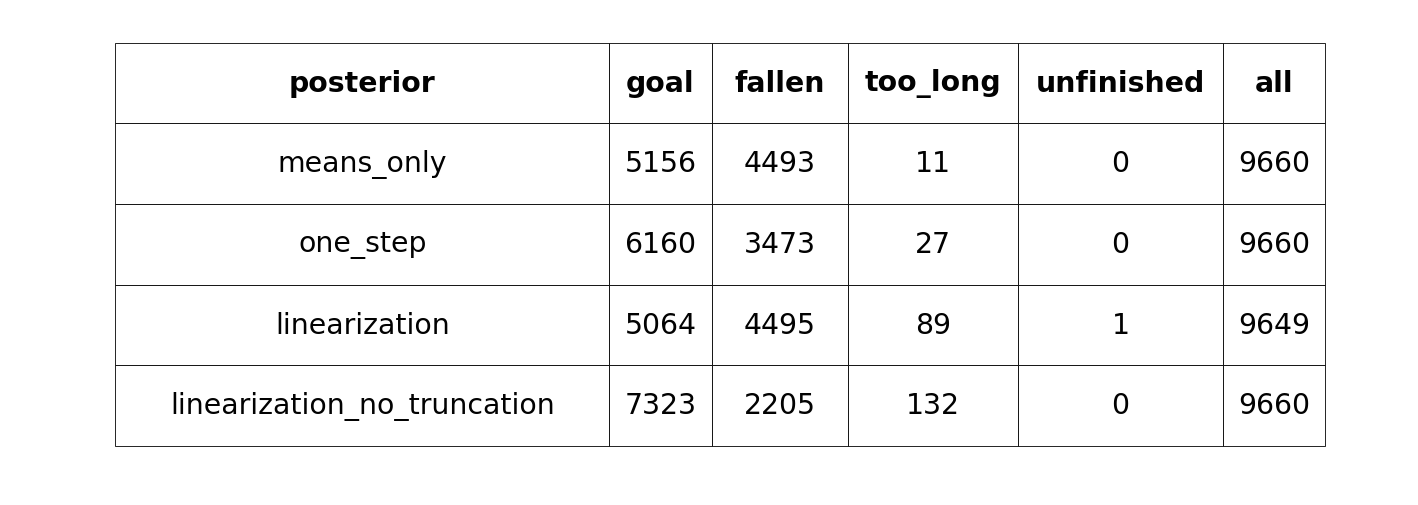

In [18]:
%%output size=400

goal_table = hv.Table(goal_collapsed, kdims=["posterior", "N", "M", "trial"], vdims=["goal", "fallen", "too_long", "unfinished", "all"])
goal_table.reduce(["N", "M", "trial"], np.sum)

b':HoloMap   [M]\n   :Table   [posterior]   (goal,fallen,too_long,unfinished,all)'
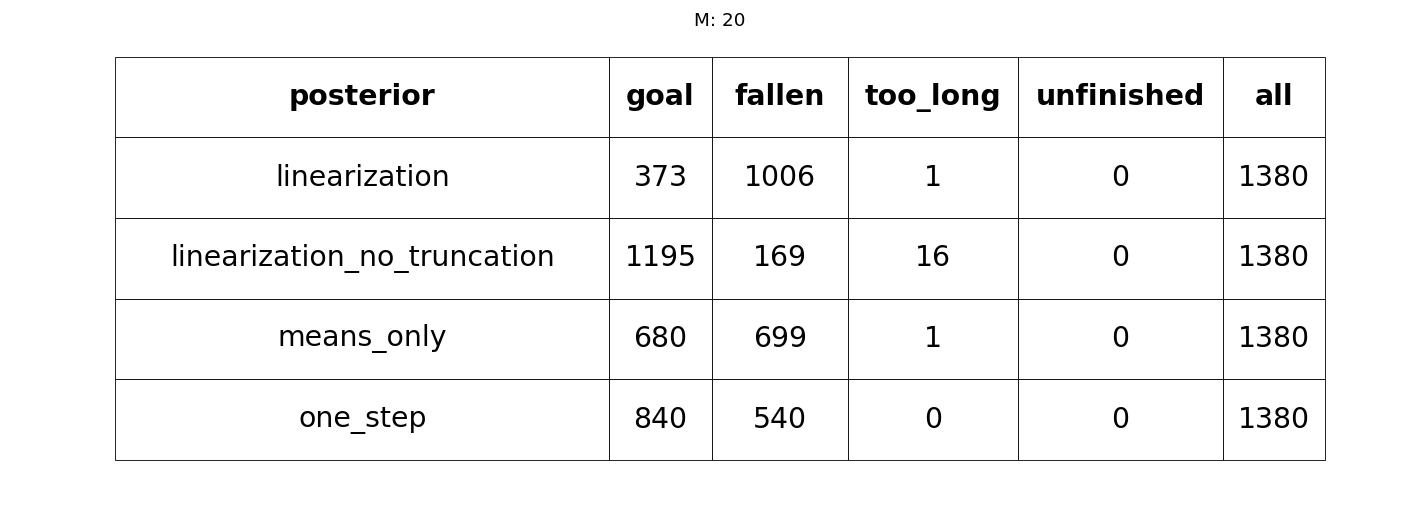
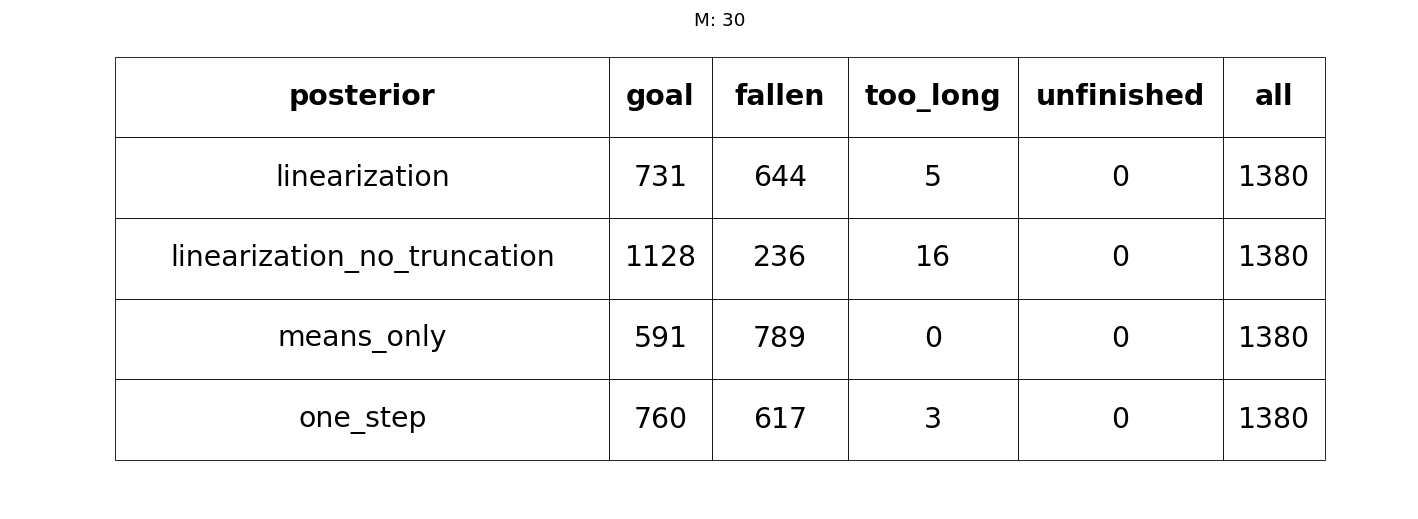
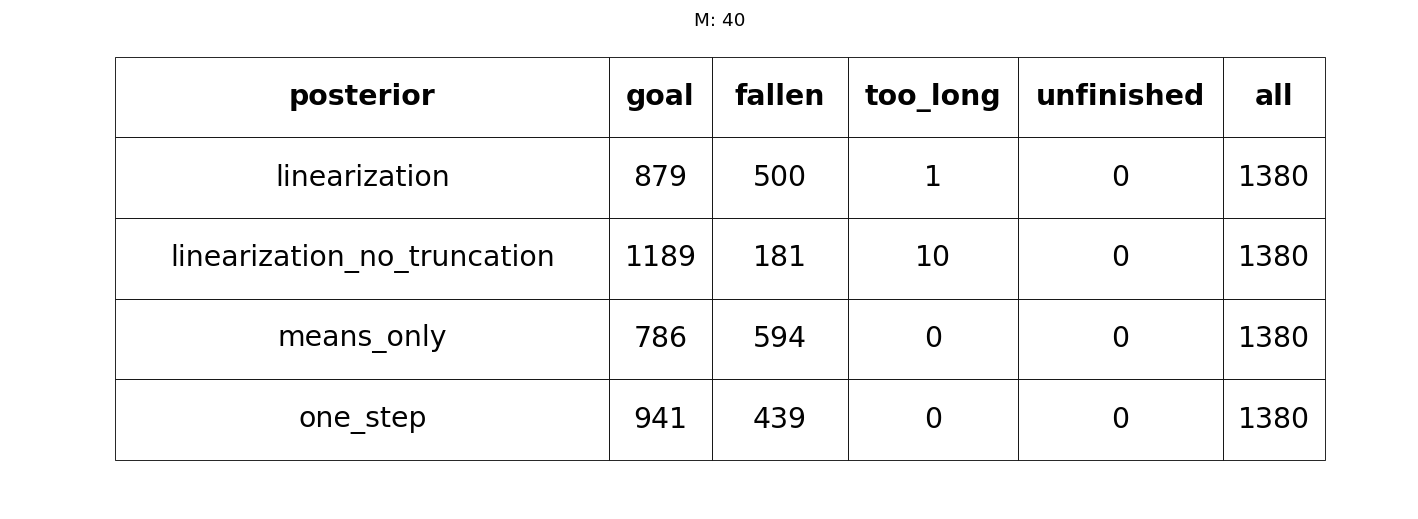
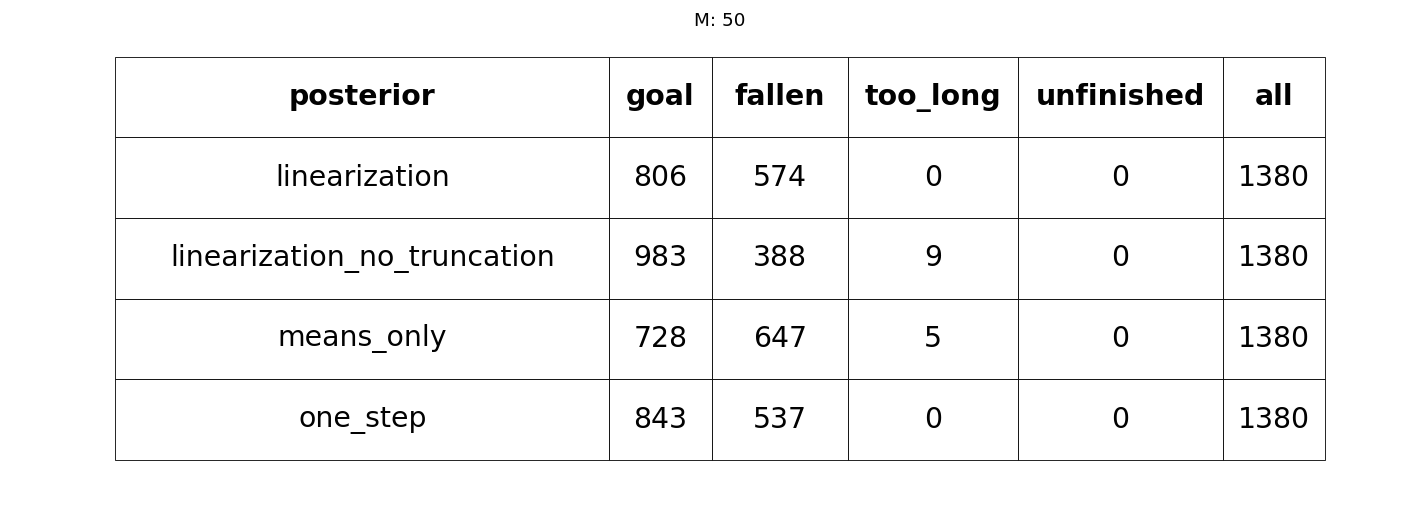
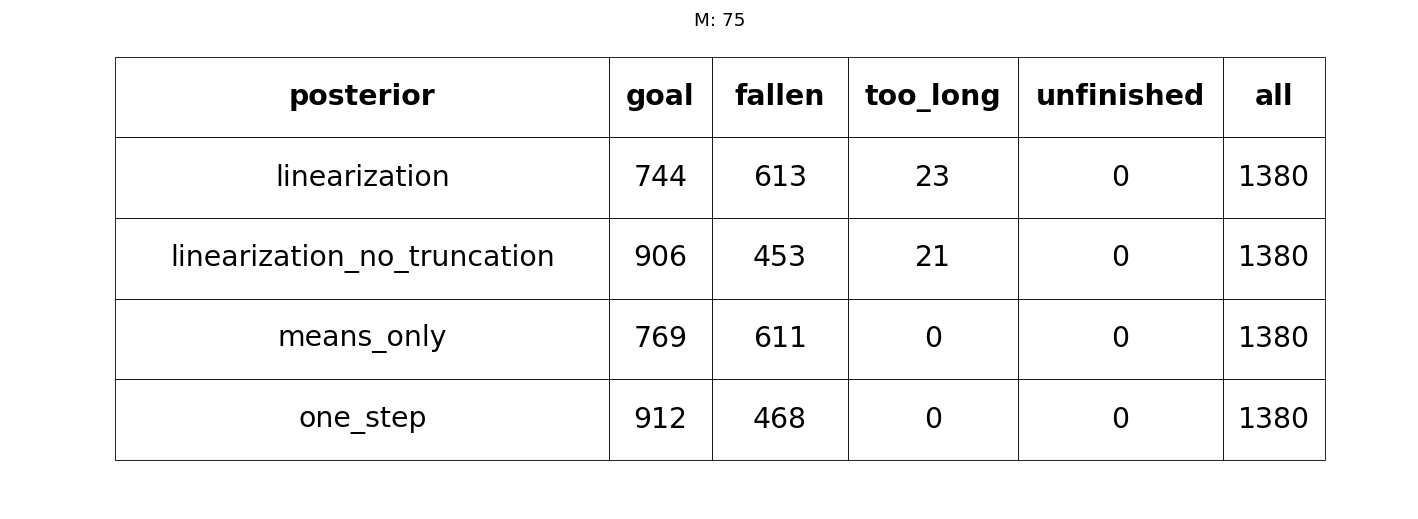
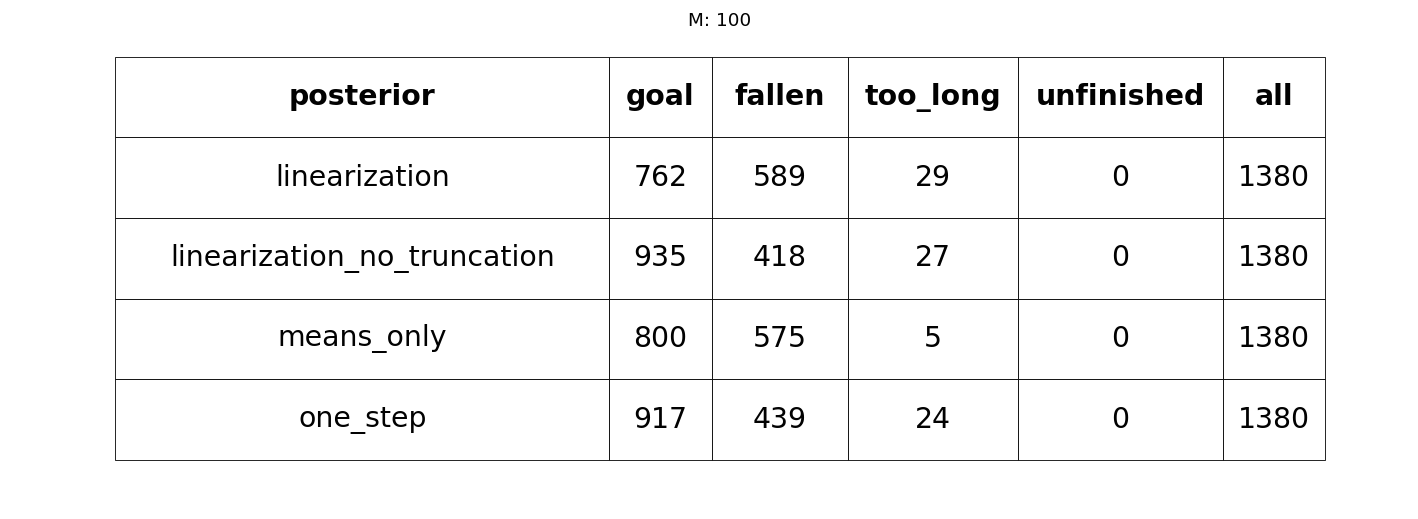
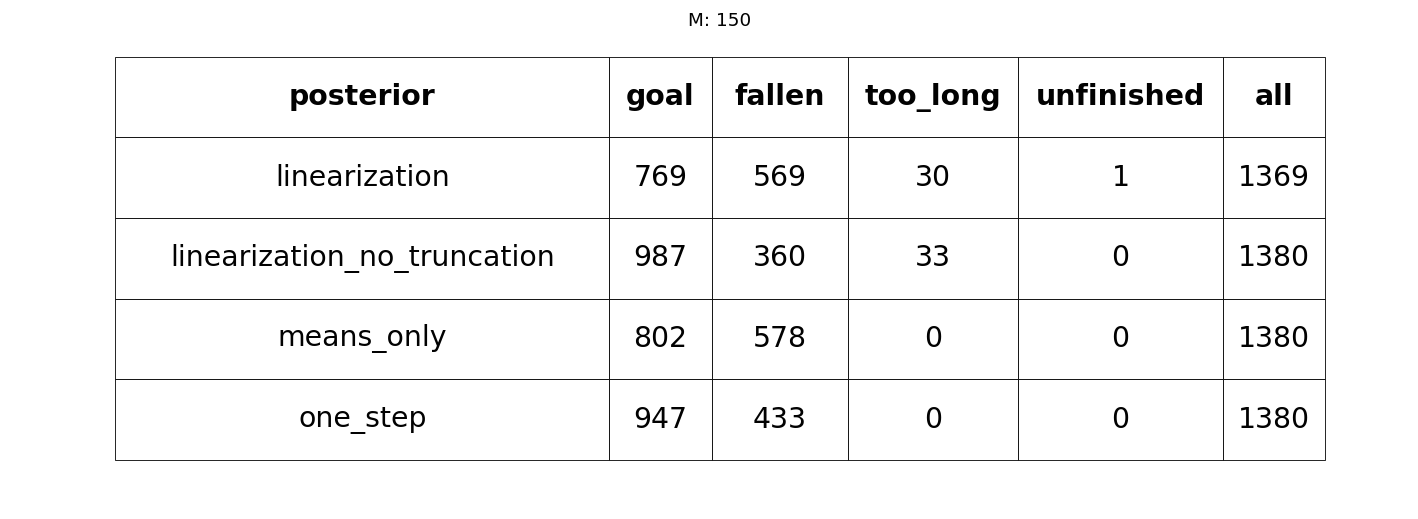

In [19]:
%%output size=400

goal_table.reduce(["N", "trial"], np.sum).sort().groupby("M")

:Overlay
   .NdOverlay.I  :NdOverlay   [posterior]
      :Spread   [M,Goal Percentage]   (Goal Percentage_sem)
   .NdOverlay.II :NdOverlay   [posterior]
      :Curve   [M,Goal Percentage]   (Goal Percentage_sem,Goal Percentage,goal,fallen,too_long,unfinished,all)
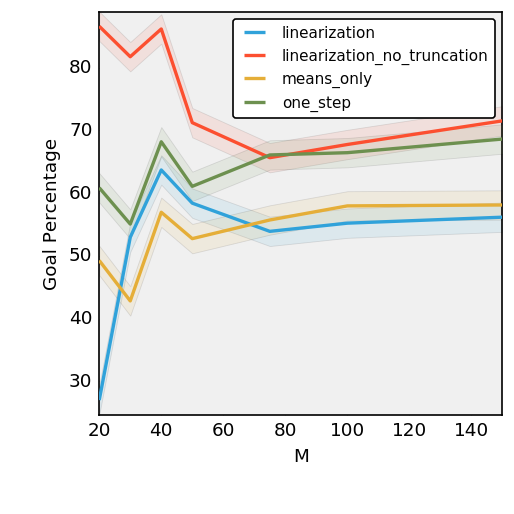

In [20]:
%%opts Spread (alpha=0.1)

reduced = goal_table.reduce(["trial", "N"], np.sum)
reduced = reduced.add_dimension("Goal Percentage", 0, 100 * reduced["goal"] / reduced["all"], vdim=True)
reduced = reduced.add_dimension("Goal Percentage_sem", 0, scipy.stats.sem(reduced["Goal Percentage"]), vdim=True)
goal_percentages = reduced
goal_percentages.to.spread(["M", "Goal Percentage"], "Goal Percentage_sem").overlay() * reduced.to.curve(["M", "Goal Percentage"]).overlay()


:Overlay
   .NdOverlay.I  :NdOverlay   [posterior]
      :Spread   [M,Goal Percentage]   (Goal Percentage_sem)
   .NdOverlay.II :NdOverlay   [posterior]
      :Curve   [M,Goal Percentage]   (Goal Percentage_sem,Goal Percentage,goal,fallen,too_long,unfinished,all)
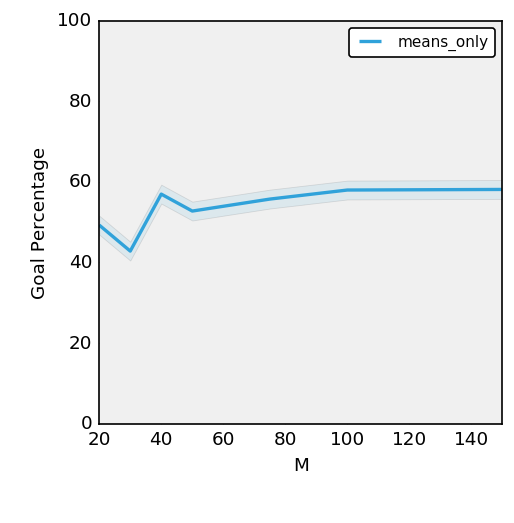

In [21]:
%%output filename="map_goal_percentage" fig="png"
%%opts Spread (alpha=0.1)

sel = reduced.select(posterior="means_only")
sel.to.spread(["M", "Goal Percentage"], "Goal Percentage_sem", extents=(20,0,150,100)).overlay() * sel.to.curve(["M", "Goal Percentage"]).overlay()

:Overlay
   .NdOverlay.I  :NdOverlay   [posterior]
      :Spread   [M,Goal Percentage]   (Goal Percentage_sem)
   .NdOverlay.II :NdOverlay   [posterior]
      :Curve   [M,Goal Percentage]   (Goal Percentage_sem,Goal Percentage,goal,fallen,too_long,unfinished,all)
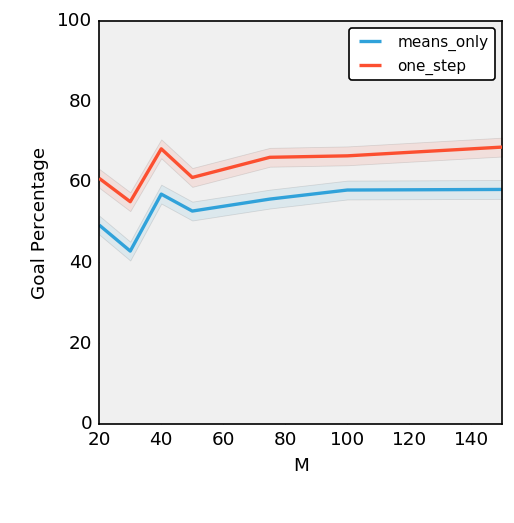

In [22]:
%%output filename="os_goal_percentage" fig="png"
%%opts Spread (alpha=0.1)

sel = reduced.select(posterior=["means_only", "one_step"])
sel.to.spread(["M", "Goal Percentage"], "Goal Percentage_sem", extents=(20,0,150,100)).overlay() * sel.to.curve(["M", "Goal Percentage"]).overlay()

:Overlay
   .NdOverlay.I  :NdOverlay   [posterior]
      :Spread   [M,Goal Percentage]   (Goal Percentage_sem)
   .NdOverlay.II :NdOverlay   [posterior]
      :Curve   [M,Goal Percentage]   (Goal Percentage_sem,Goal Percentage,goal,fallen,too_long,unfinished,all)
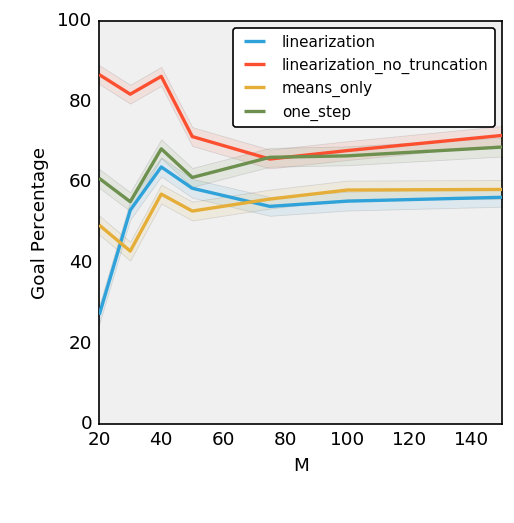

In [23]:
%%output filename="ms_goal_percentage" fig="png"
%%opts Spread (alpha=0.1)

sel = reduced
sel.to.spread(["M", "Goal Percentage"], "Goal Percentage_sem", extents=(20,0,150,100)).overlay() * sel.to.curve(["M", "Goal Percentage"]).overlay()

# Last Rewards

In [24]:
last_evals = [
    {
        parse_path(name): item
        for name, item in one["last_reward"].items()
    }
    for one in all_evals
]

long_last_evals = [
    {
        (*name, ix, i): v
        for name, item in one.items()
        for i, v in enumerate(item)
    }
    for ix, one in enumerate(last_evals)
]

last_collapsed = collapse_evals(long_last_evals)

b':Table   [posterior,trajectory]   (last_reward)'
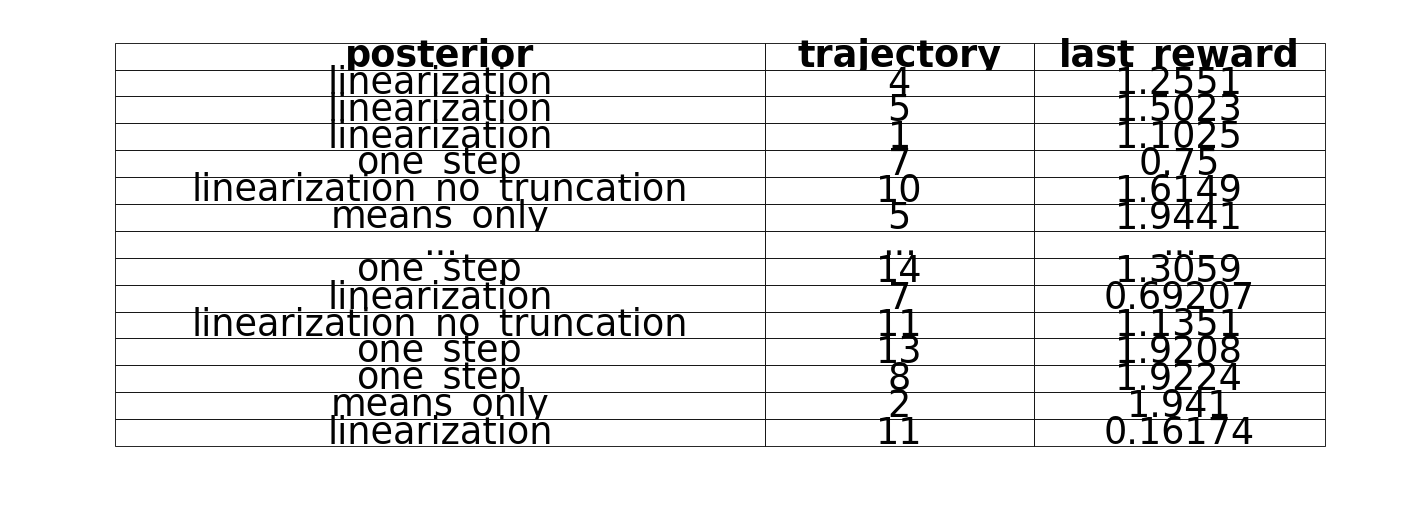

In [25]:
%%output size=400

last_table = hv.Table(last_collapsed, kdims=["posterior", "N", "M", "trial", "trajectory"], vdims=["last_reward"])
last_table.reduce(["N", "M", "trial"], np.mean)

:Layout
   .Table.I  :Table   [posterior]   (count,last_reward)
   .Table.II :Table   [posterior]   (goal,fallen,too_long,unfinished,all)
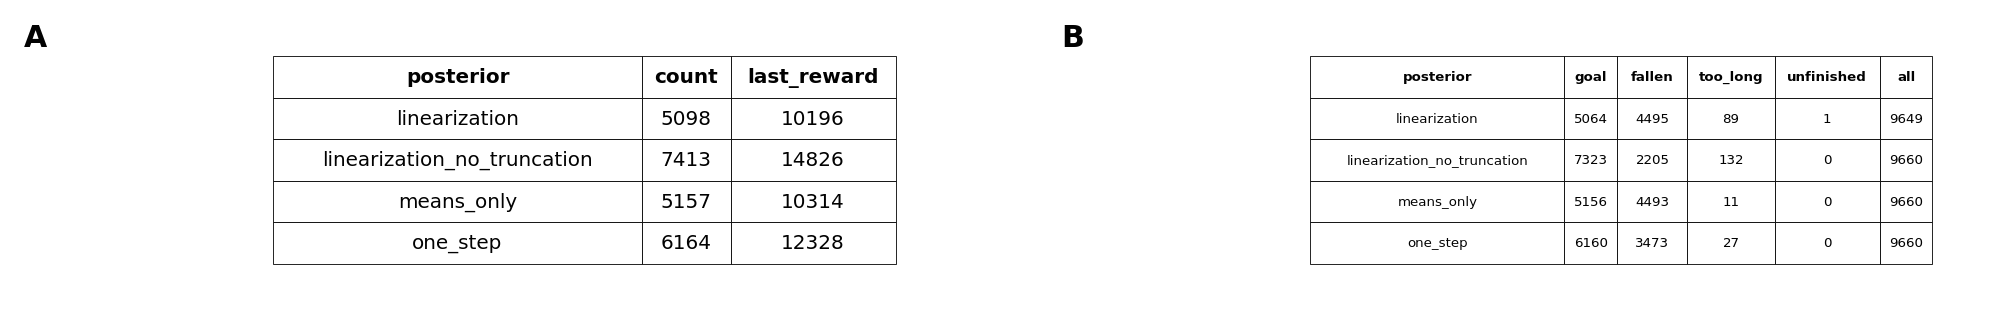

In [26]:
%%output size=200

full_table = last_table.select(last_reward=(1.9, 2.1)).add_dimension("count", 0, 1, vdim=True).reduce(["N", "M", "trial", "trajectory"], np.sum)
full_table.sort() + goal_table.reduce(["N", "M", "trial"], np.sum).sort()

# Time to Goal

In [27]:
time_evals = [
    {
        parse_path(name): item
        for name, item in one["time_to_goal"].items()
    }
    for one in all_evals
]

long_time_evals = [
    {
        (*name, ix, i): v
        for name, item in one.items()
        for i, v in enumerate(item)
    }
    for ix, one in enumerate(time_evals)
]

time_collapsed = collapse_evals(long_time_evals)

b':Table   [posterior]   (time_to_goal)'
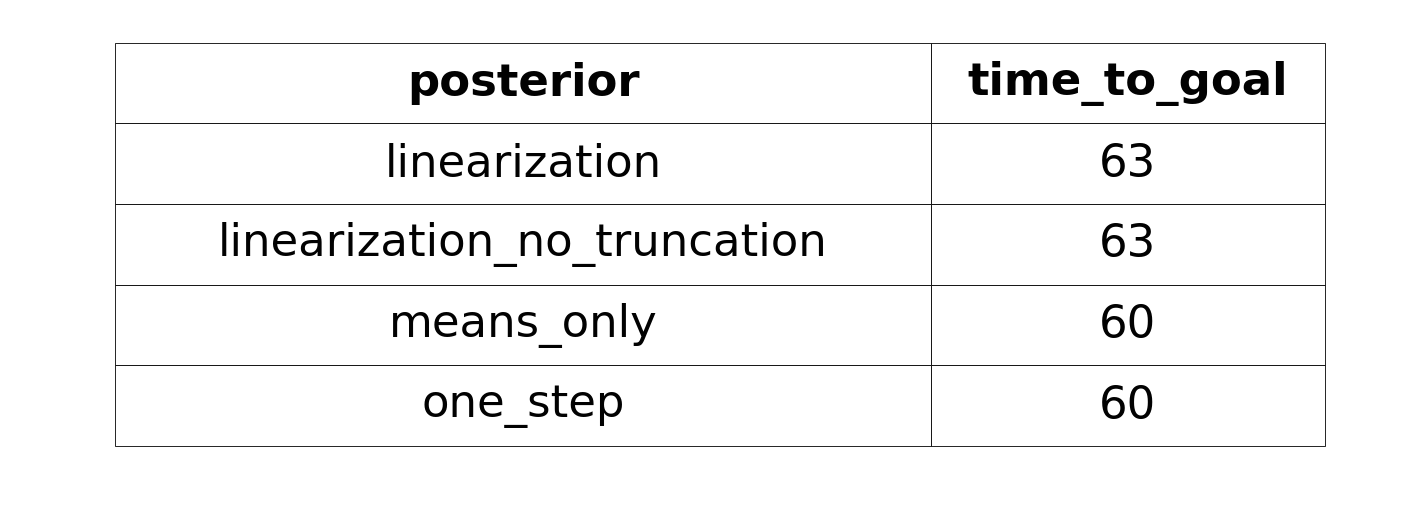

In [28]:
%%output size=400

time_table = hv.Table(time_collapsed, kdims=["posterior", "N", "M", "trial", "trajectory"], vdims=["time_to_goal"]).select(time_to_goal=(0,1e6))
time_table.sort().reduce(["N", "M", "trial", "trajectory"], np.median)

b':Table   [posterior]   (time_to_goal)'
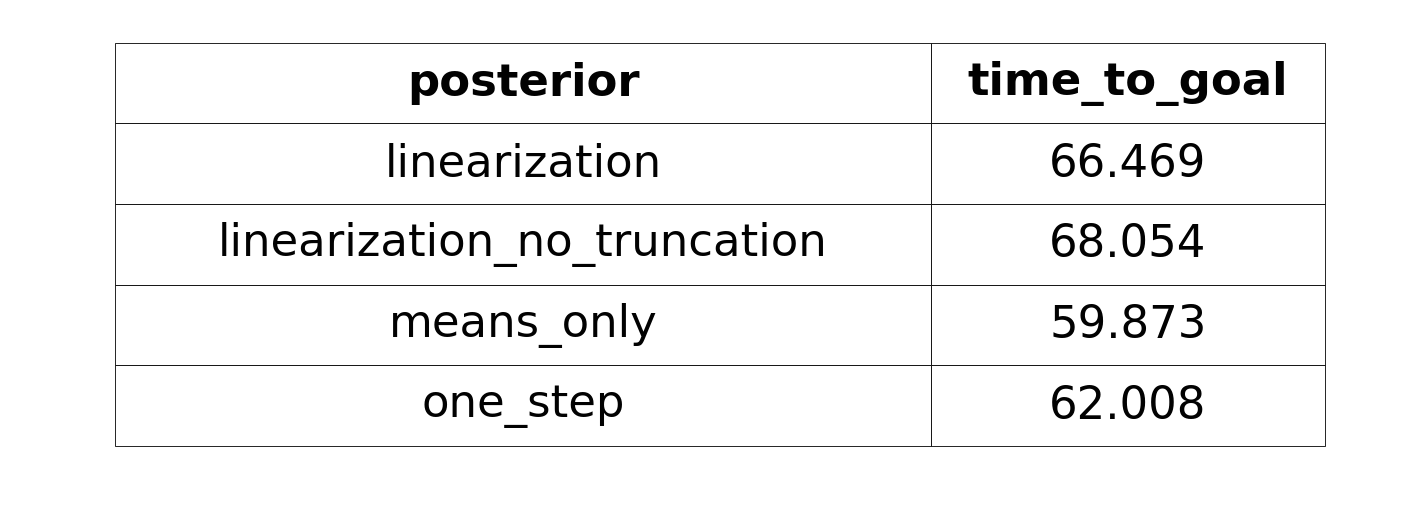

In [29]:
%%output size=400

time_table.sort().reduce(["N", "M", "trial", "trajectory"], np.mean)

b':NdOverlay   [posterior]\n   :Curve   [M,time_to_goal]   (time_to_goal)'
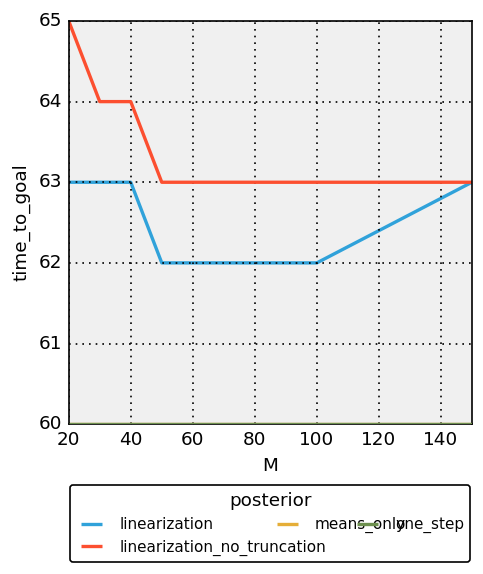

In [30]:
reduced = time_table.reduce(["trial", "N", "trajectory"], np.median)
reduced.to.curve(["M", "time_to_goal"]).overlay()

b':NdLayout   [posterior]\n   :HoloMap   [M]\n      :Distribution   (time_to_goal)'
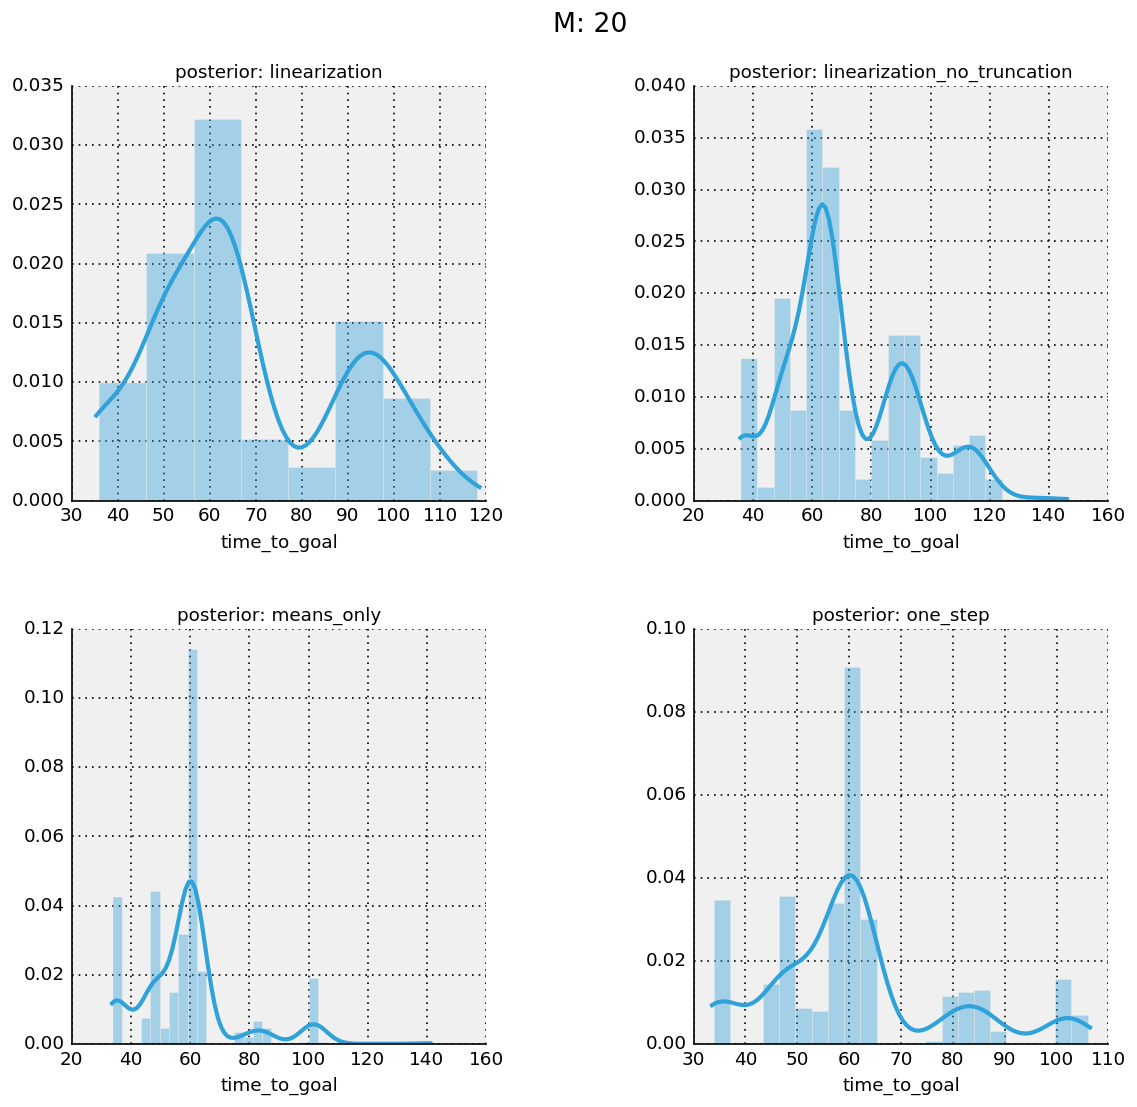
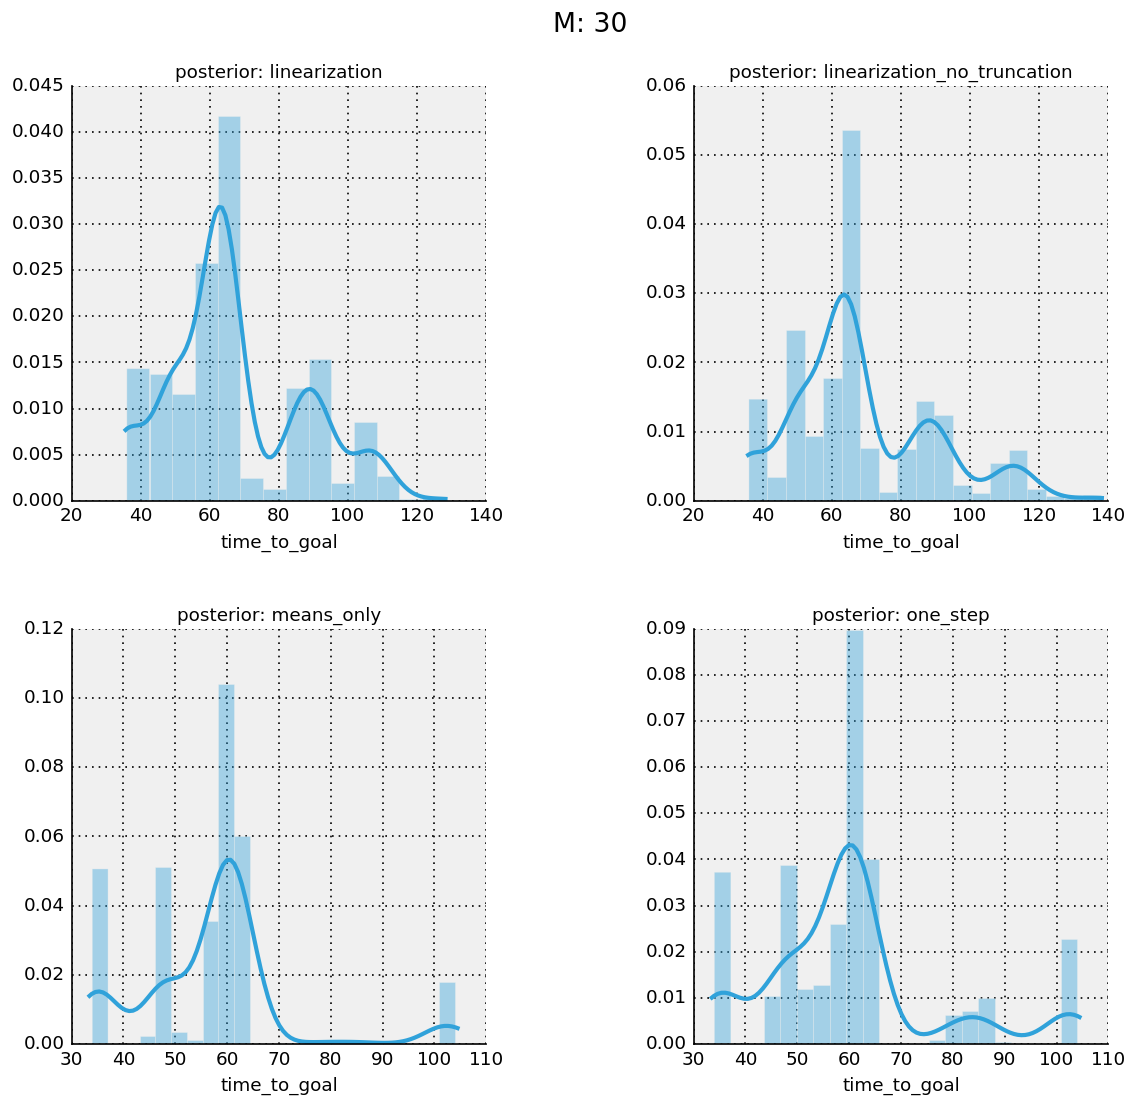
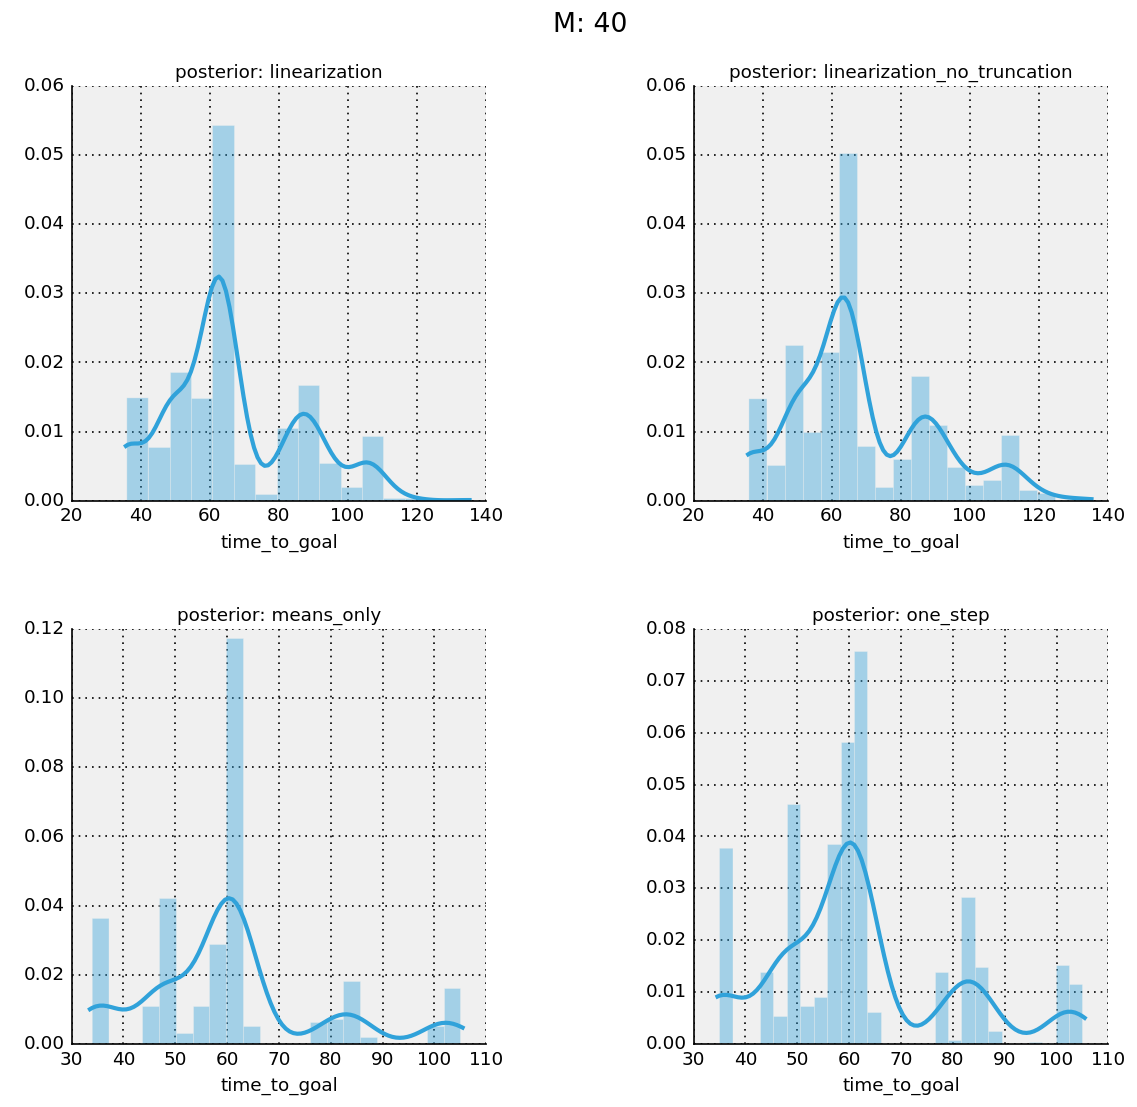
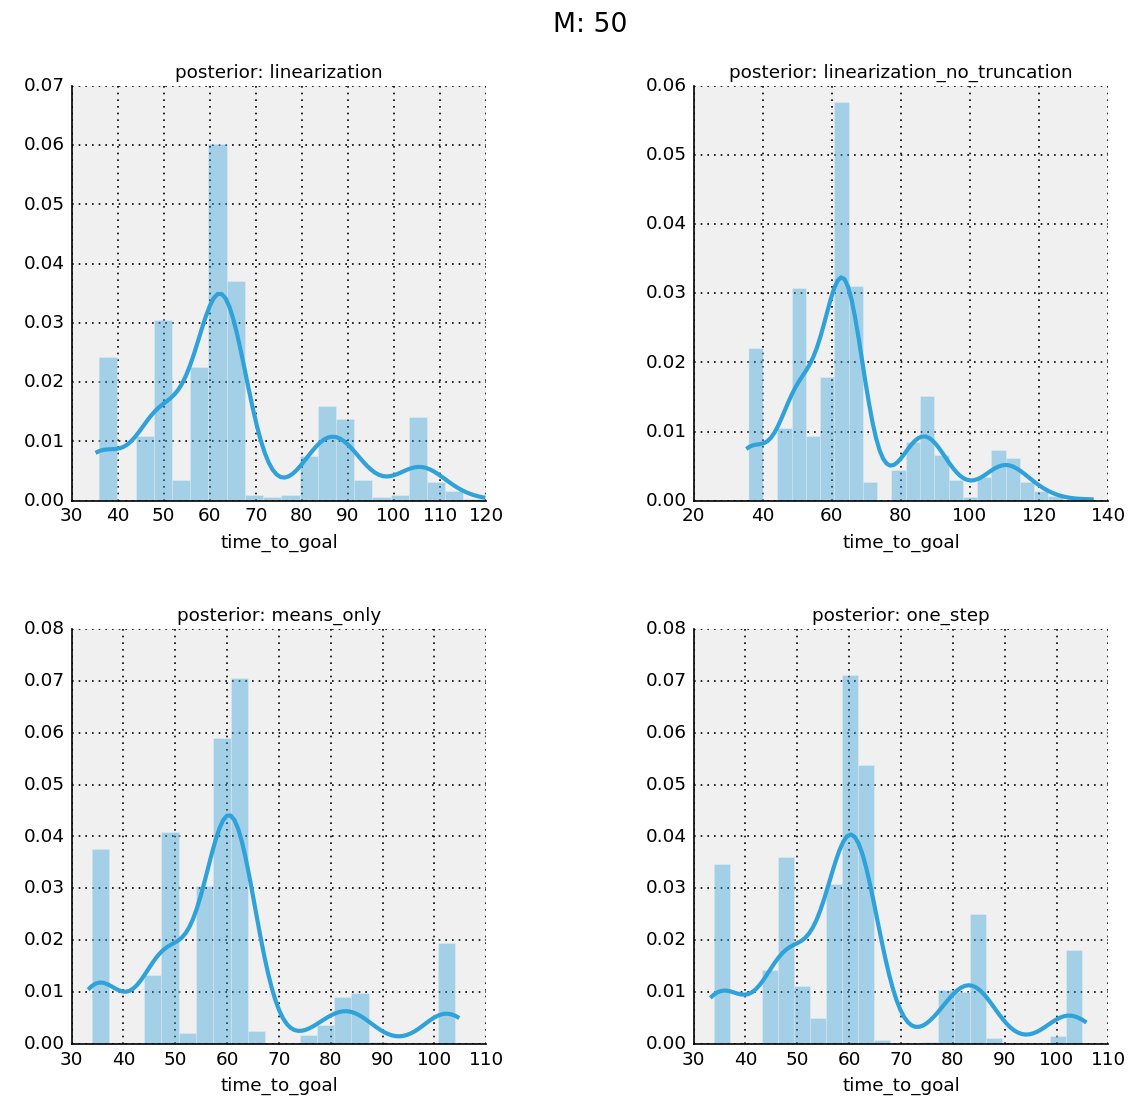
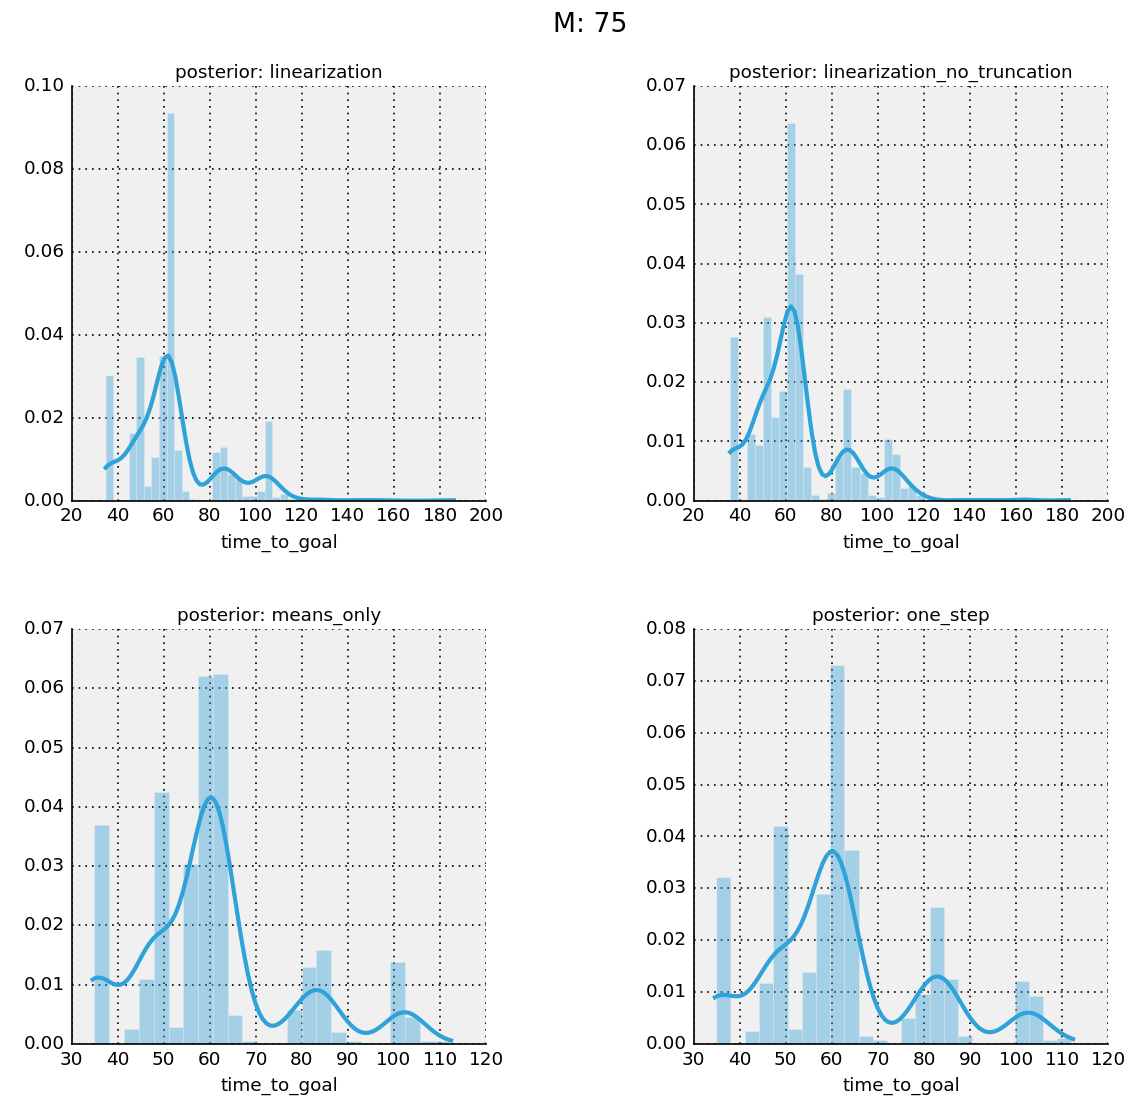
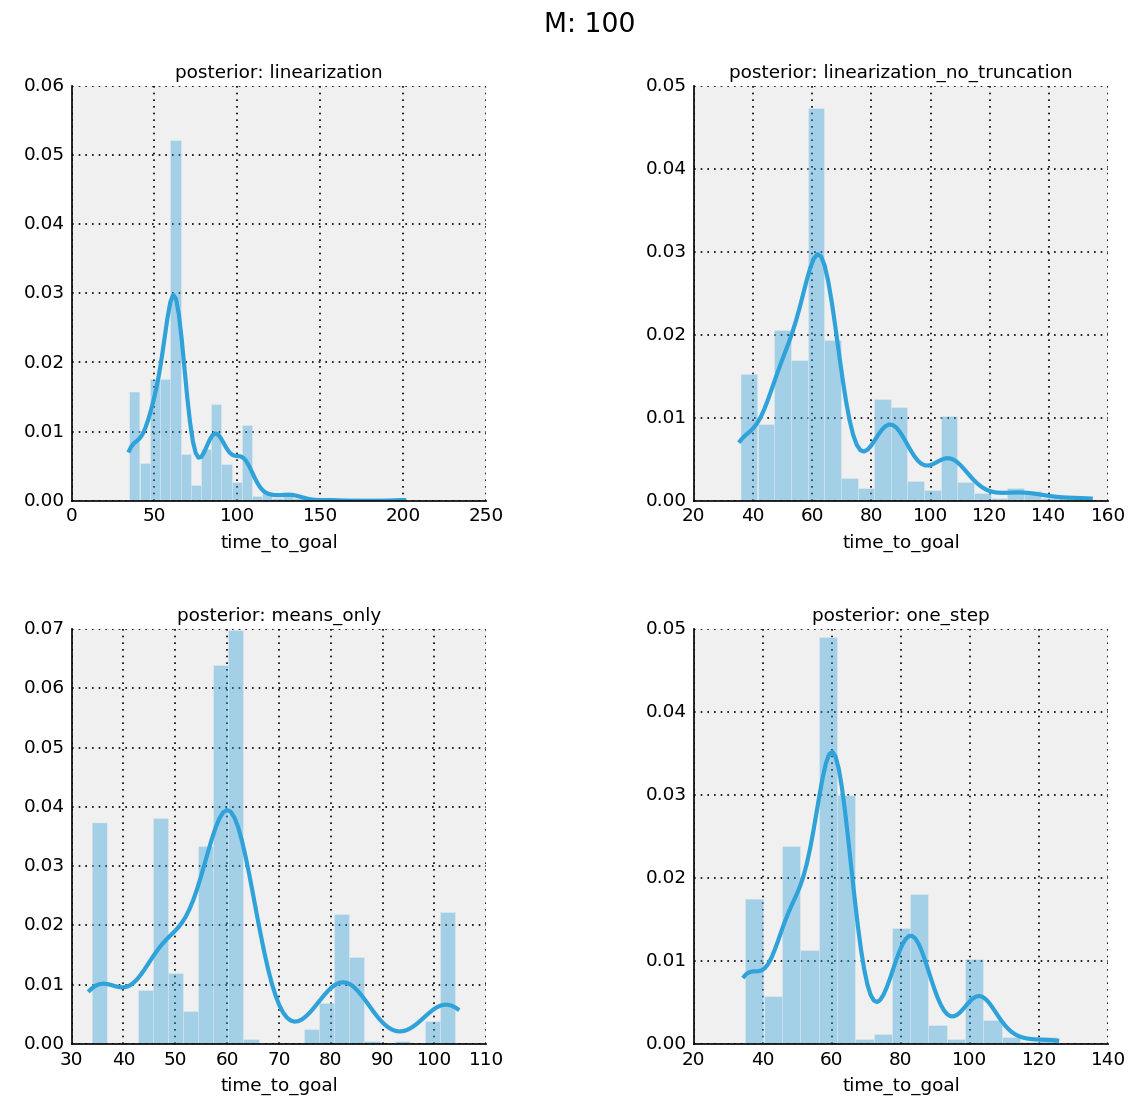
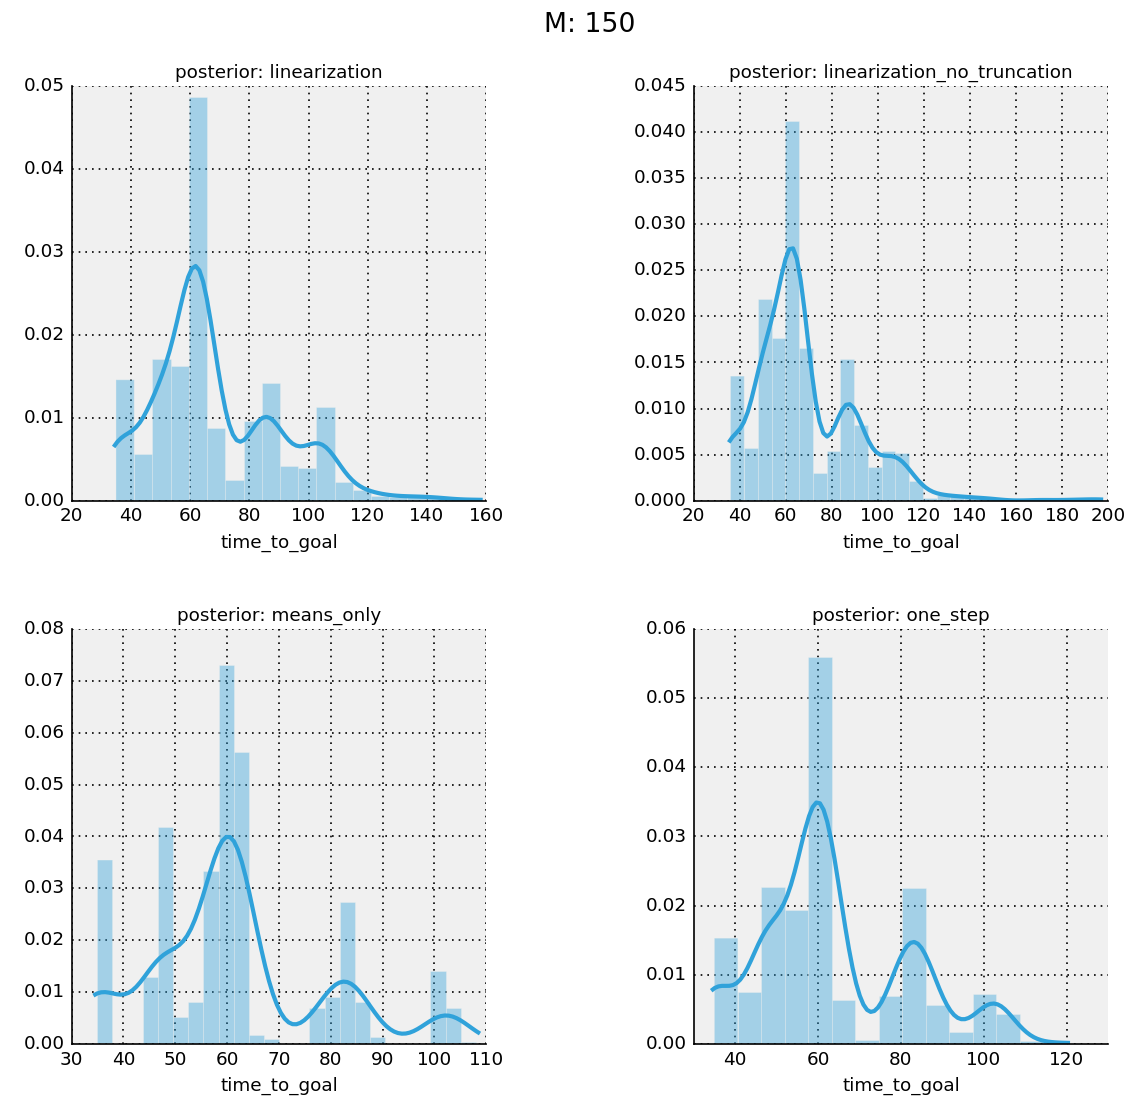

In [31]:
%%opts Distribution[apply_extents=True] HoloMap[apply_extents=True]
time_table.to.distribution("time_to_goal", mdims=["M", "posterior"]).layout("posterior").cols(2)

b':NdLayout   [posterior]\n   :Distribution   (time_to_goal)'
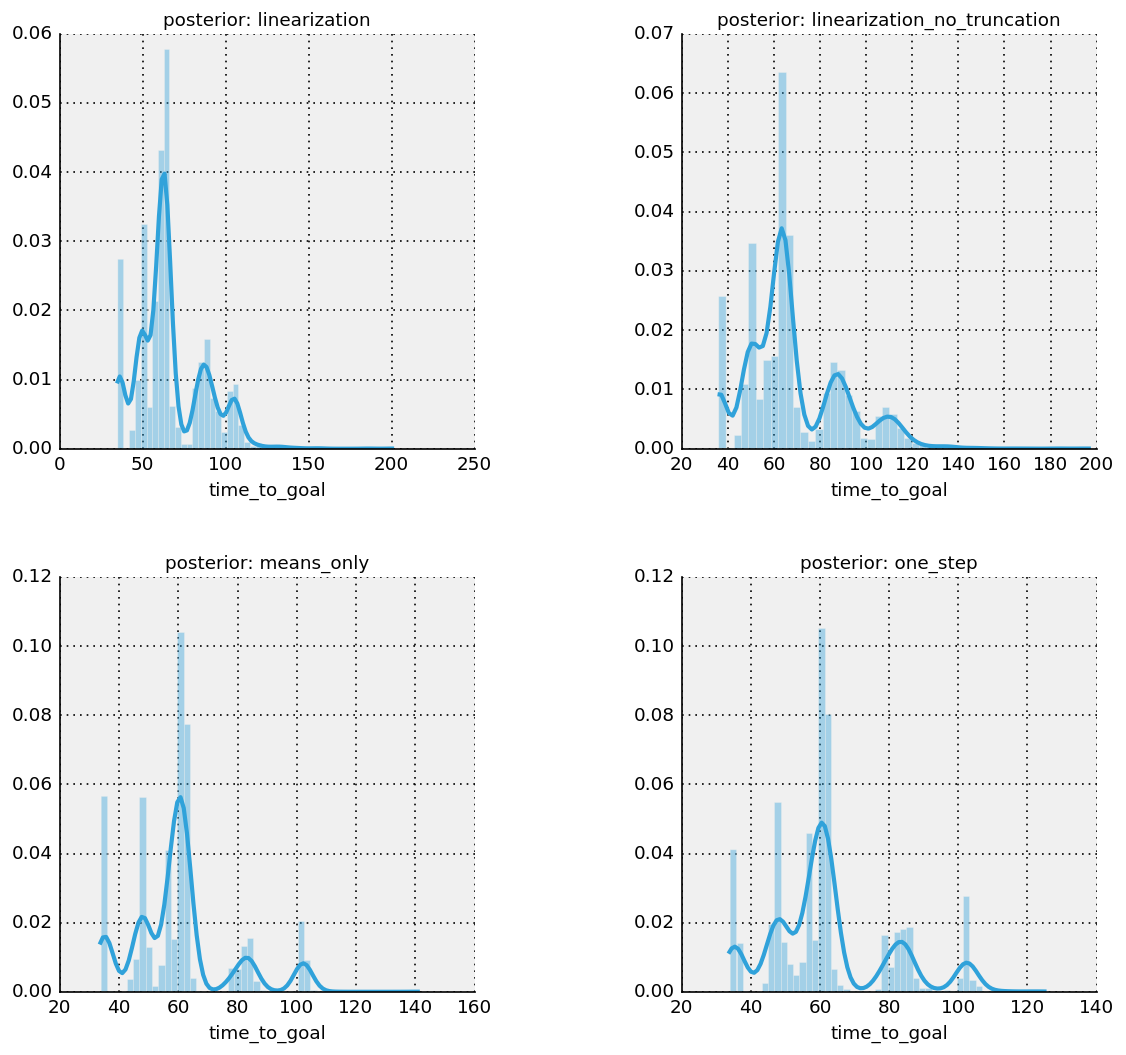

In [32]:
%%opts Distribution[apply_extents=True] HoloMap[apply_extents=True]
time_table.to.distribution("time_to_goal", mdims=["posterior"]).layout("posterior").cols(2)

# Export for Thesis

In [68]:
reward_df = pd.DataFrame(mean_mean_rewards.data)
reward_df = reward_df[["posterior", "M", "Mean-Mean-Reward", "Mean-Mean-Reward_sem"]]
reward_df.columns = ["posterior", "M", "reward", "reward_sem"]
reward_df_pivot = reward_df.pivot(index="M", columns="posterior")
reward_df_pivot.columns = ['_'.join(reversed(col)) for col in reward_df_pivot.columns.values]
reward_df_pivot.to_csv("results_mean_mean_rewards.dat")

In [63]:
goal_df = pd.DataFrame(goal_percentages.data)
goal_df = goal_df[["posterior", "M", "Goal Percentage_sem", "Goal Percentage"]]
goal_df.columns = ["posterior", "M", "percentage_sem", "percentage"]
goal_df_pivot = goal_df.pivot(index="M", columns="posterior")
goal_df_pivot.columns = ['_'.join(reversed(col)) for col in goal_df_pivot.columns.values]
goal_df_pivot.to_csv("results_goal_percentage.dat")